# Analysis of the Box-Counting Dimension of Metal Nanoparticles

This notebook contains the results from the analysis of the relationships between nanoparticle structural features and the box-counting dimensions, $D_B$, computed for metal (specifically the mono-, bi-, and tri-metallic combinations of gold, palladium, and platinum) nanoparticles. The $D_B$ values are computed using [Sphractal](https://github.com/jon-ting/sphractal), a Python package for the estimation of the fractal dimension of the surfaces of atomistic objects via box-counting approaches.

## Outline

[Notebook Setups](#setup)

[Data Sets](#datasets)

[Monometallic Nanoparticles](#mnps)

[Bimetallic Nanoparticles](#bnps)

[Trimetallic Nanoparticles](#tnps)

<a id='setup'></a>
## Notebook Setups

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Import relevant libraries
from os import chdir, listdir
import pickle
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn

from natsort import natsorted
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

chdir('/scratch/q27/jt5911')  # To be modified accordingly
from trainEvalModels import rmNullLowVarFeats, rmHighCorrFeats
from corrAnalysis import *

# Print package versions for reproducibility
print('Versions of imported libraries:')
print(f"  matplotlib: {mpl.__version__}")
print(f"  numpy: {np.__version__}")
print(f"  pandas: {pd.__version__}")
print(f"  seaborn: {sns.__version__}")
print(f"  scikit-learn: {sklearn.__version__}")

Versions of imported libraries:
  matplotlib: 3.8.2
  numpy: 1.24.4
  pandas: 2.1.4
  seaborn: 0.13.1
  scikit-learn: 1.4.0


Below are some general settings for plotting figures:

In [7]:
# Settings for figures
sns.set_theme(context='paper', style='ticks', palette='colorblind', font='sans-serif', font_scale=1, color_codes=True, rc=None)  # Options are: {paper, notebook, talk, poster}
figSize, DPI, fontSize, labelSize = (3.5, 2.5), None, 'medium', 'small'
legendSize, lineWidth, markerSize = 'x-small', 1, 3
SMALL_SIZE, MEDIUM_SIZE, LARGE_SIZE, TITLE_SIZE = 8, 10, 12, 14
plt.rc('font', size=LARGE_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=TITLE_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=LARGE_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=LARGE_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=LARGE_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=LARGE_SIZE)  # legend fontsize
plt.rc('figure', titlesize=TITLE_SIZE)  # fontsize of the figure title
# PLOT_COLOURS = ['#212121', '#3F51B5', '#303F9F', '#FF5252', '#D32F2F']  # black, blue, deep blue, red, deep red from https://www.materialpalette.com
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#303F9F', '#FF5252', '#D32F2F'])

In [8]:
# Figure settings & Global variables for analysis of correlations between box-counting dimension with features
sns.set_palette('deep')

import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)

RANDOM_SEED = 42
X_CI = 'sd'
CI = 95
N_BOOT = 1000
ORDER = 1
LOG_X = False
THRESH_PERC = 0.1

Some handy global variables:

In [9]:
VAR_THRESH = 0.0  # Value other than 0.0 is difficult to decide non-arbitrarily
VERBOSE = True
TRANS_FRAC = True
FIG_DIR = 'figures'
DATA_DIR = 'data'

Some handy general functions:

In [10]:
def readPickle(picklePath):
    with open(picklePath, 'rb') as f: 
        df = pickle.load(f)
    df['rangeLenVX'] = df.apply(lambda f: f['maxLenVX'] - f['minLenVX'], axis=1)
    df['rangeLenEX'] = df.apply(lambda f: f['maxLenEX'] - f['minLenEX'], axis=1)
    return df

In [11]:
def loadCSV(csvFilePath, isMono=True, molLabels=True, ele='Au', transFrac=True):
    """
    The monometallic dataset has different naming for certain features, hence why 'isMono' needs to be specified.
    """
    featDF = pd.read_csv(csvFilePath, sep=',', header=0)
    

    if isMono:
        featDF = featDF.rename(columns={'N_total': 'N_atom_total', 'N_bulk': 'N_atom_bulk', 'N_surface': 'N_atom_surface', 
                                        'Avg_total': 'TCN_avg', 'Avg_bulk': 'BCN_avg', 'Avg_surf': 'SCN_avg', 
                                        'Avg_bonds': 'BL_avg', 'Std_bonds': 'BL_std', 'Max_bonds': 'BL_max', 'Min_bonds': 'BL_min', 'N_bonds': 'BL_num',
                                        'angle_avg': 'BA1_avg', 'angle_std': 'BA1_std'}, 
                               inplace=False)
        eleSpecificFeats = [feat for feat in featDF.columns if 'CN_' in feat 
                                                            or 'BL_' in feat
                                                            or 'BA1_' in feat]
        # Rename and generate element-specific features to match bimetallic and trimetallic feature names
        eleSpecNewFeatNamesDict = {}
        for feat in eleSpecificFeats:
            eleSpecNewFeatName = f"MMM_{feat}" if 'BA1_' in feat else f"MM_{feat}"
            eleSpecNewFeatNamesDict[feat] = eleSpecNewFeatName
            eleSpecNewFeatName = f"{ele}{ele}{ele}_{feat}" if 'BA1_' in feat else f"{ele}{ele}_{feat}"
            featDF[eleSpecNewFeatName] = featDF[feat]
        featDF = featDF.rename(columns=eleSpecNewFeatNamesDict, inplace=False)
            
        # Rename q6q6 features to match bimetallic and trimetallic q6q6 feature names
        q6q6Feats = [feat for feat in featDF.columns if 'q6q6_T' in feat or 'q6q6_B' in feat or 'q6q6_S' in feat]
        q6q6NewFeatNamesDict = {}
        for feat in q6q6Feats:
            q6q6NewFeatName = f"{feat[:6]}_{feat[6:]}"
            q6q6NewFeatNamesDict[feat] = q6q6NewFeatName
        featDF = featDF.rename(columns=q6q6NewFeatNamesDict, inplace=False)
    
    # Replace count features with percentages
    if transFrac:
        bulkAtomFeats = [feat for feat in featDF.columns if ('BCN' in feat and '_avg' not in feat)
                                                         or ('BGCN' in feat and '_avg' not in feat)
                                                         or ('q6q6_B' in feat and '_avg' not in feat)]
        surfAtomFeats = [feat for feat in featDF.columns if 'N_Au' in feat or 'N_Pd' in feat or 'N_Pt' in feat
                                                         or ('SCN' in feat and '_avg' not in feat)
                                                         or ('SGCN' in feat and '_avg' not in feat)
                                                         or ('SOCN' in feat and '_avg' not in feat)
                                                         or ('SOGCN' in feat and '_avg' not in feat)
                                                         or ('q6q6_S' in feat and '_avg' not in feat)
                                                         or 'Curve' in feat
                                                         or 'S_100' in feat
                                                         or 'S_111' in feat
                                                         or 'S_110' in feat
                                                         or 'S_311' in feat]
        totAtomFeats = [feat for feat in featDF.columns if 'N_Au' in feat or 'N_Pd' in feat or 'N_Pt' in feat
                                                        or ('TCN' in feat and '_avg' not in feat)
                                                        or ('TGCN' in feat and '_avg' not in feat)
                                                        or ('q6q6_T' in feat and '_avg' not in feat)
                                                        or 'FCC' in feat 
                                                        or 'HCP' in feat
                                                        or 'ICOS' in feat
                                                        or 'DECA' in feat]
        numBulkAtomFeat = featDF['N_atom_bulk']
        numSurfAtomFeat = featDF['N_atom_surface']
        numTotalAtomFeat = featDF['N_atom_total']
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            for feat in bulkAtomFeats:
                featDF[f"Frac_{feat}"] = featDF[feat] / numBulkAtomFeat
            for feat in surfAtomFeats:
                if 'N_Au' in feat or 'N_Pd' in feat or 'N_Pt' in feat:
                    featDF[f"Frac_{feat}_Surf"] = featDF[feat] / numSurfAtomFeat
                else:
                    featDF[f"Frac_{feat}"] = featDF[feat] / numSurfAtomFeat
            for feat in totAtomFeats:
                featDF[f"Frac_{feat}"] = featDF[feat] / numTotalAtomFeat
        # featDF.drop(bulkAtomFeats, axis=1, inplace=True)
        # featDF.drop(surfAtomFeats, axis=1, inplace=True)
        # featDF.drop(totAtomFeats, axis=1, inplace=True)

    for feat  in featDF.columns.tolist():
        if 'Vol' in feat:  # Turn the units of volumes from cubic angstroms into cubic metres
            featDF[feat] = featDF[feat].apply(lambda x: 1e-30 / x)
        elif 'R_' in feat:  # Turn the units of radii into nanometres
            featDF[feat] = featDF[feat].apply(lambda x: x / 10)
        if feat == 'R_avg':  # Compute average diameter (nm)
            diameterFeat = featDF[feat].rename(feat.replace('R_avg', 'D_avg')) * 2
            featDF = pd.concat([featDF, diameterFeat], axis=1)
    labelFeats = [feat for feat in featDF.columns if 'Surf_defects' in feat or 'Surf_micros' in feat or 'Surf_facets' in feat or '_E' in feat]
    labelDF = featDF[labelFeats]
    featDF.drop(['ID'] + labelFeats, axis=1, inplace=True)
    return featDF, labelDF

In [12]:
def countNumHypothesis(df, feats, splitFeat='Elements'):
    numHypothesis = 0
    for feat in feats:
        print(f"Feature: {feat}")
        try:
            df[feat]
            for category in df[splitFeat].unique():
                catDF = df.loc[:, [feat, 'DBoxEX']][df[splitFeat] == category].dropna(axis=0, how='any', subset=feat)
                if len(catDF) == 0:
                    print(f"    Category {category} doesn't have entry!")
                    continue
                numHypothesis += 1
        except KeyError:
            print('  Feature not found!')
            continue
    print(f"{numHypothesis} hypotheses, Bonferroni corrected p-value: {0.05 / numHypothesis:.6f}")
    return numHypothesis

<a id='datasets'></a>
## Data Sets

The data sets used here are atomic coordinates of simulated metal nanoparticles generated for studies on the impact of polydispersivity on the properties of metal nanoparticle electrocatalyst ensembles. All data sets are hosted at [CSIRO Data Access Portal](https://data.csiro.au/collection/). The links are provided below:
- [gold](https://data.csiro.au/collection/csiro:40669)
- [palladium](https://data.csiro.au/collection/csiro:40618)
- [platinum](https://data.csiro.au/collection/csiro:36491)
- [gold-palladium](https://data.csiro.au/collection/csiro:58177) and [palladium-gold](https://data.csiro.au/collection/csiro:58481)
- [gold-platinum](https://data.csiro.au/collection/csiro:58477) and [platinum-gold](https://data.csiro.au/collection/csiro:58484)
- [palladium-platinum](https://data.csiro.au/collection/csiro:58483) and [platinum-palladium](https://data.csiro.au/collection/csiro:58487)
- [gold-palladium-platinum](https://data.csiro.au/collection/csiro:58474)

The bimetallic nanoparticle data sets are much larger (in the order of hundred thousands) than the monometallic (in the order of thousands) and the trimetallic (in the order of ten thousands). Hence, data reduction was conducted on these data sets prior to these studies.

<a id='mnps'></a>
## Monometallic Nanoparticles

Here we process the data for the simulated monometallic nanoparticles (either gold, palladium, or platinum).

### Data Loading

In [ ]:
# Load features
# Gold nanoparticle data set doesn't contain these labels: {Surf_defects_*, Surf_micros_*, Surf_facets_*}
AuFeatsDF, AuOriLabelsDF = loadCSV('data/Au_nanoparticle_dataset.csv', isMono=True, molLabels=False, ele='Au', transFrac=TRANS_FRAC)  
PdFeatsDF, PdOriLabelsDF = loadCSV('data/Pd_nanoparticle_dataset.csv', isMono=True, molLabels=True, ele='Pd', transFrac=TRANS_FRAC)
PtFeatsDF, PtOriLabelsDF = loadCSV('data/Pt_nanoparticle_dataset.csv', isMono=True, molLabels=True, ele='Pt', transFrac=TRANS_FRAC)
MNPFeatsDF = pd.concat([AuFeatsDF, PdFeatsDF, PtFeatsDF], axis=0)
MNPFeatsDF = MNPFeatsDF.reset_index(inplace=False)
MNPFeatsDF = MNPFeatsDF.drop(['index'], axis=1, inplace=False)

# # Load labels and extract useful label column(s)
feats = ['DBoxEX']  # 'R2EX', 'minLenEX', 'maxLenEX', 'rangeLenEX', 'lowCIEX', 'upCIEX'
AuLabelsDF = readPickle('data/allAuNPsEX.pickle')
AuLabelDF = AuLabelsDF[feats]
AuLabelDF = AuLabelDF.reset_index(inplace=False)
AuLabelDF = AuLabelDF.drop(['index'], axis=1, inplace=False)
PdLabelsDF = readPickle('data/allPdNPsEX.pickle')
PdLabelDF = PdLabelsDF[feats]
PdLabelDF = PdLabelDF.reset_index(inplace=False)
PdLabelDF = PdLabelDF.drop(['index'], axis=1, inplace=False)
PtLabelsDF = readPickle('data/allPtNPsEX.pickle')
PtLabelDF = PtLabelsDF[feats]
PtLabelDF = PtLabelDF.reset_index(inplace=False)
PtLabelDF = PtLabelDF.drop(['index'], axis=1, inplace=False)
MNPLabelDF = pd.concat([AuLabelDF, PdLabelDF, PtLabelDF], axis=0)
MNPLabelDF = MNPLabelDF.reset_index(inplace=False)
MNPLabelDF = MNPLabelDF.drop(['index'], axis=1, inplace=False)

print(f"Default labels for Au nanoparticle dataset: {AuOriLabelsDF.columns.tolist()}\n")
print(f"Default labels for Pd nanoparticle dataset: {PdOriLabelsDF.columns.tolist()}\n")
print(f"Default labels for Pt nanoparticle dataset: {PtOriLabelsDF.columns.tolist()}\n")
print(f"Current label for all datasets: {MNPLabelDF.columns[-1]}\n")

# Not using the original labels in this notebook, delete variables to free up memory
del AuOriLabelsDF, PdOriLabelsDF, PtOriLabelsDF, AuLabelsDF, PdLabelsDF, PtLabelsDF

In [ ]:
# Identification of the IDs of Pd NPs within a certain range of size (number of atoms) for bond angle deviation from FCC structure investigation
fcc = PdFeatsDF['Frac_FCC'][PdFeatsDF['N_atom_total'] > 900][PdFeatsDF['N_atom_total'] < 1000]  # Limit the size range of Pd NP
print(fcc.index[np.where(fcc == fcc.max())[0][0]])  # Pd NP with the highest fraction of atoms in FCC packing
print(fcc.index[np.where(fcc == fcc.min())[0][0]])  # Pd NP with the lowest fraction of atoms in FCC packing

### Data Processing

##### Feature Selection

In [ ]:
# Remove features with zero variance and the second feature of each highly correlated feature pairs
CORR_THRESH = 1.0
print('Au nanoparticles:')
AuFeatsNoLowVarDF = rmNullLowVarFeats(featsDF=AuFeatsDF, rmNull=False, varThresh=VAR_THRESH, verbose=VERBOSE)
AuFeatsNoLowVarHighCorrDF = rmHighCorrFeats(featsDF=AuFeatsNoLowVarDF, corrThresh=CORR_THRESH, verbose=VERBOSE)
print('Pd nanoparticles:')
PdFeatsNoLowVarDF = rmNullLowVarFeats(featsDF=PdFeatsDF, rmNull=False, varThresh=VAR_THRESH, verbose=VERBOSE)
PdFeatsNoLowVarHighCorrDF = rmHighCorrFeats(featsDF=PdFeatsNoLowVarDF, corrThresh=CORR_THRESH, verbose=VERBOSE)
print('Pt nanoparticles:')
PtFeatsNoLowVarDF = rmNullLowVarFeats(featsDF=PtFeatsDF, rmNull=False, varThresh=VAR_THRESH, verbose=VERBOSE)
PtFeatsNoLowVarHighCorrDF = rmHighCorrFeats(featsDF=PtFeatsNoLowVarDF, corrThresh=CORR_THRESH, verbose=VERBOSE)
print('All monometallic nanoparticles:')
MNPFeatsNoLowVarDF = rmNullLowVarFeats(featsDF=MNPFeatsDF, rmNull=False, varThresh=VAR_THRESH, verbose=VERBOSE)
MNPFeatsNoLowVarHighCorrDF = rmHighCorrFeats(featsDF=MNPFeatsNoLowVarDF, corrThresh=CORR_THRESH, verbose=VERBOSE)

del AuFeatsNoLowVarDF, PdFeatsNoLowVarDF, PtFeatsNoLowVarDF, MNPFeatsNoLowVarDF

##### Data Analysis

In [ ]:
# Correlation heatmap
fig, ax = plt.subplots(figsize=(10, 8), dpi=DPI)
sns.set(font_scale=1.4)
g = sns.heatmap(AuFeatsNoLowVarHighCorrDF.corr(), ax=ax)
plt.savefig(f"{FIG_DIR}/AuNoC{int(CORR_THRESH * 100)}CorrHeatmap.png", bbox_inches='tight')

fig, ax = plt.subplots(figsize=(10, 8), dpi=DPI)
sns.set(font_scale=1.4)
g = sns.heatmap(PdFeatsNoLowVarHighCorrDF.corr(), ax=ax)
plt.savefig(f"{FIG_DIR}/PdNoC{int(CORR_THRESH * 100)}CorrHeatmap.png", bbox_inches='tight')

fig, ax = plt.subplots(figsize=(10, 8), dpi=DPI)
sns.set(font_scale=1.4)
g = sns.heatmap(PtFeatsNoLowVarHighCorrDF.corr(), ax=ax)
plt.savefig(f"{FIG_DIR}/PtNoC{int(CORR_THRESH * 100)}CorrHeatmap.png", bbox_inches='tight')

fig, ax = plt.subplots(figsize=(10, 8), dpi=DPI)
sns.set(font_scale=1.4)
g = sns.heatmap(MNPFeatsNoLowVarHighCorrDF.corr(), ax=ax)
plt.savefig(f"{FIG_DIR}/MNPNoC{int(CORR_THRESH * 100)}CorrHeatmap.png", bbox_inches='tight')

In [ ]:
# Merge labels with features
print('Au nanoparticles:')
AuNPDF = pd.concat([AuFeatsNoLowVarHighCorrDF, AuLabelDF], axis=1)
display(AuNPDF)
display(AuNPDF.describe())
del AuFeatsNoLowVarHighCorrDF

print('Pd nanoparticles:')
PdNPDF = pd.concat([PdFeatsNoLowVarHighCorrDF, PdLabelDF], axis=1)
display(PdNPDF)
display(PdNPDF.describe())
del PdFeatsNoLowVarHighCorrDF

print('Pt nanoparticles:')
PtNPDF = pd.concat([PtFeatsNoLowVarHighCorrDF, PtLabelDF], axis=1)
display(PtNPDF)
display(PtNPDF.describe())
del PtFeatsNoLowVarHighCorrDF

print('All monometallic nanoparticles:')
MNPDF = pd.concat([MNPFeatsNoLowVarHighCorrDF, MNPLabelDF], axis=1)
display(MNPDF)
display(MNPDF.describe())
del MNPFeatsNoLowVarHighCorrDF

In [ ]:
# Correlation of Each Feature with Box-Counting Dimension Obtained from Exact Surface Representation
# for col in AuNPDF.columns:
#     g = sns.regplot(data=AuNPDF, x=col, y='DBoxEX')
#     g.figure.set_size_inches(4, 3)
#     plt.show()

# for col in PdNPDF.columns:
#     g = sns.regplot(data=PdNPDF, x=col, y='DBoxEX')
#     g.figure.set_size_inches(4, 3)
#     plt.show()

# for col in PtNPDF.columns:
#     g = sns.regplot(data=PtNPDF, x=col, y='DBoxEX')
#     g.figure.set_size_inches(4, 3)
#     plt.show()

# for col in MNPDF.columns:
#     g = sns.regplot(data=MNPDF, x=col, y='DBoxEX')
#     g.figure.set_size_inches(4, 3)
#     plt.show()

In [ ]:
# Top Correlated Features with Box-Counting Dimensions
sns.set_theme(context='paper', style='ticks', palette='colorblind', font='sans-serif', font_scale=1, color_codes=True, rc=None)

AuHighCorrFeats = AuNPDF.corr()['DBoxEX'].sort_values(ascending=False, key=abs)
PdHighCorrFeats = PdNPDF.corr()['DBoxEX'].sort_values(ascending=False, key=abs)
PtHighCorrFeats = PtNPDF.corr()['DBoxEX'].sort_values(ascending=False, key=abs)
MNPHighCorrFeats = MNPDF.corr()['DBoxEX'].sort_values(ascending=False, key=abs)

# All features
# numFeats = None
# plotFeatsBCDcorrBar(featsDBoxCorrDF=AuHighCorrFeats, NPname='Au', numFeats=numFeats, corrThresh=CORR_THRESH)
# plotFeatsBCDcorrBar(featsDBoxCorrDF=PdHighCorrFeats, NPname='Pd', numFeats=numFeats, corrThresh=CORR_THRESH)
# plotFeatsBCDcorrBar(featsDBoxCorrDF=PtHighCorrFeats, NPname='Pt', numFeats=numFeats, corrThresh=CORR_THRESH)
# plotFeatsBCDcorrBar(featsDBoxCorrDF=MNPHighCorrFeats, NPname='MNP', numFeats=numFeats, corrThresh=CORR_THRESH)

# Top 20 features
numFeats = 20
plotFeatsBCDcorrBar(featsDBoxCorrDF=AuHighCorrFeats, NPname='Au', numFeats=numFeats, corrThresh=CORR_THRESH)
plotFeatsBCDcorrBar(featsDBoxCorrDF=PdHighCorrFeats, NPname='Pd', numFeats=numFeats, corrThresh=CORR_THRESH)
plotFeatsBCDcorrBar(featsDBoxCorrDF=PtHighCorrFeats, NPname='Pt', numFeats=numFeats, corrThresh=CORR_THRESH)
plotFeatsBCDcorrBar(featsDBoxCorrDF=MNPHighCorrFeats, NPname='MNP', numFeats=numFeats, corrThresh=CORR_THRESH)

##### Data Storage

In [ ]:
with open(f"{DATA_DIR}/processedMNPdataNoC{int(CORR_THRESH * 100)}.pickle", 'wb') as f:
    pickle.dump([AuNPDF, PdNPDF, PtNPDF, MNPDF], f)

del AuNPDF, AuHighCorrFeats
del PdNPDF, PdHighCorrFeats
del PtNPDF, PtHighCorrFeats
del MNPDF, MNPHighCorrFeats

### Correlations between Box-Counting Dimension and Other Features

In [ ]:
# Create master dataframe
AuLabelDF['Elements'] = 'Au'
PdLabelDF['Elements'] = 'Pd'
PtLabelDF['Elements'] = 'Pt'
MNPLabelDF = pd.concat([AuLabelDF, PdLabelDF, PtLabelDF], axis=0)
MNPLabelDF = MNPLabelDF.reset_index(inplace=False)
MNPLabelDF = MNPLabelDF.drop(['index'], axis=1, inplace=False)
MNPDF = pd.concat([MNPFeatsNoLowVarHighCorrDF, MNPLabelDF], axis=1)
MNPDF = MNPDF.rename({'q6q6_avg_total': 'q6q6_T_avg', 'q6q6_avg_bulk': 'q6q6_B_avg', 'q6q6_avg_surf': 'q6q6_S_avg'}, axis=1)

In [ ]:
# Distribution of box-counting dimension
plotBCDhist(df=MNPDF, splitFeat='Elements', xLims=(2.00, 2.65), threshLines=True)

# Statistics
sigDiffMNPDF = compareRoughSmoothStats(df=MNPDF)
sigDiffMNPDF

In [ ]:
# Group features
processFeats = ['T', 'tau', 'time']
npStatsFeats = ['N_atom_total', 'N_atom_bulk', 'N_atom_surface', 'Volume',
                'R_min', 'R_max', 'R_diff', 'R_avg', 'R_std', 'R_skew', 'R_kurt', 'D_avg']
facetFeats = ['S_100', 'S_111', 'S_110', 'S_311', 'Frac_S_100', 'Frac_S_111', 'Frac_S_110', 'Frac_S_311']
curvFeats = [feat for feat in MNPDF.columns if 'Curve' in feat]
tcnFeats = [feat for feat in MNPDF.columns if 'MM_TCN' in feat]
bcnFeats = [feat for feat in MNPDF.columns if 'MM_BCN' in feat]
scnFeats = [feat for feat in MNPDF.columns if 'MM_SCN' in feat]
blFeats = [feat for feat in MNPDF.columns if 'MM_BL' in feat]
baFeats = [feat for feat in MNPDF.columns if 'MMM_BA' in feat]
crysFeats = ['FCC', 'HCP', 'ICOS', 'DECA', 'Frac_FCC', 'Frac_HCP', 'Frac_ICOS', 'Frac_DECA']
q6q6tFeats = [feat for feat in MNPDF.columns if 'q6q6_T' in feat]
q6q6bFeats = [feat for feat in MNPDF.columns if 'q6q6_B' in feat]
q6q6sFeats = [feat for feat in MNPDF.columns if 'q6q6_S' in feat]

In [ ]:
# Correlations between box-counting dimension and features
plotFeatsBCDcorr(df=MNPDF, feats=processFeats, figNameAppend='MNP', sciNotation=['tau'], titleName='Elements', showPlot=True)
plotFeatsBCDcorr(df=MNPDF, feats=npStatsFeats, figNameAppend='MNP', sciNotation=['N_atom_total', 'N_atom_bulk', 'N_atom_surface'], 
                 titleName='Elements', showPlot=True)
plotFeatsBCDcorr(df=MNPDF, feats=facetFeats, figNameAppend='MNP', sciNotation=['S_100', 'S_111', 'S_110', 'S_311'], 
                 titleName='Elements', showPlot=True)
plotFeatsBCDcorr(df=MNPDF, feats=curvFeats, figNameAppend='MNP', sciNotation=curvFeats, titleName='Elements', showPlot=True)
plotFeatsBCDcorr(df=MNPDF, feats=tcnFeats, figNameAppend='MNP', titleName='Elements', showPlot=True)
plotFeatsBCDcorr(df=MNPDF, feats=bcnFeats, figNameAppend='MNP', titleName='Elements', showPlot=True)
plotFeatsBCDcorr(df=MNPDF, feats=scnFeats, figNameAppend='MNP', titleName='Elements', showPlot=True)
plotFeatsBCDcorr(df=MNPDF, feats=blFeats, figNameAppend='MNP', titleName='Elements', showPlot=True)
plotFeatsBCDcorr(df=MNPDF, feats=baFeats, figNameAppend='MNP', titleName='Elements', showPlot=True)
plotFeatsBCDcorr(df=MNPDF, feats=crysFeats, figNameAppend='MNP', titleName='Elements', sciNotation=['Frac_ICOS'], showPlot=True)
plotFeatsBCDcorr(df=MNPDF, feats=q6q6tFeats, figNameAppend='MNP', titleName='Elements', showPlot=True)
plotFeatsBCDcorr(df=MNPDF, feats=q6q6bFeats, figNameAppend='MNP', titleName='Elements', showPlot=True)
plotFeatsBCDcorr(df=MNPDF, feats=q6q6sFeats, figNameAppend='MNP', titleName='Elements', showPlot=True)

In [ ]:
# Calculate the number of hypotheses for Bonferroni correction
feats = processFeats + npStatsFeats + facetFeats + curvFeats + tcnFeats + bcnFeats + scnFeats + blFeats + baFeats + crysFeats + q6q6tFeats + q6q6bFeats + q6q6sFeats
splitFeat = 'Elements'
numHypothesis = countNumHypothesis(df=MNPDF, feats=feats, splitFeat='Elements')

In [ ]:
mis = calcMIs(df=MNPDF, feats=processFeats, splitFeat='Elements', numHypothesis=numHypothesis)
mis = calcMIs(df=MNPDF, feats=npStatsFeats, splitFeat='Elements', numHypothesis=numHypothesis)
mis = calcMIs(df=MNPDF, feats=facetFeats, splitFeat='Elements', numHypothesis=numHypothesis)
mis = calcMIs(df=MNPDF, feats=curvFeats, splitFeat='Elements', numHypothesis=numHypothesis)
mis = calcMIs(df=MNPDF, feats=tcnFeats, splitFeat='Elements', numHypothesis=numHypothesis)
mis = calcMIs(df=MNPDF, feats=bcnFeats, splitFeat='Elements', numHypothesis=numHypothesis)
mis = calcMIs(df=MNPDF, feats=scnFeats, splitFeat='Elements', numHypothesis=numHypothesis)
mis = calcMIs(df=MNPDF, feats=blFeats, splitFeat='Elements', numHypothesis=numHypothesis)
mis = calcMIs(df=MNPDF, feats=baFeats, splitFeat='Elements', numHypothesis=numHypothesis)
mis = calcMIs(df=MNPDF, feats=crysFeats, splitFeat='Elements', numHypothesis=numHypothesis)
mis = calcMIs(df=MNPDF, feats=q6q6tFeats, splitFeat='Elements', numHypothesis=numHypothesis)
mis = calcMIs(df=MNPDF, feats=q6q6bFeats, splitFeat='Elements', numHypothesis=numHypothesis)
mis = calcMIs(df=MNPDF, feats=q6q6sFeats, splitFeat='Elements', numHypothesis=numHypothesis)

<a id='bnps'></a>
## Bimetallic Nanoparticles

Here we process the data for the simulated bimetallic nanoparticles (consisting of combinations of gold, palladium, and platinum).

### Data Loading

In [ ]:
# Load features
# For AuPt nanoparticle data set, 'confID' was manually changed to 'ID' for consistency with other datasets to avoid errors
AuPdFeats, AuPdOriLabels = loadCSV('data/AuPd_nanoparticle_nonredundant_dataset.csv', isMono=False, molLabels=True, transFrac=TRANS_FRAC)
AuPtFeats, AuPtOriLabels = loadCSV('data/AuPt_nanoparticle_nonredundant_dataset.csv', isMono=False, molLabels=True, transFrac=TRANS_FRAC)  
PdAuFeats, PdAuOriLabels = loadCSV('data/PdAu_nanoparticle_nonredundant_dataset.csv', isMono=False, molLabels=True, transFrac=TRANS_FRAC)
PdPtFeats, PdPtOriLabels = loadCSV('data/PdPt_nanoparticle_nonredundant_dataset.csv', isMono=False, molLabels=True, transFrac=TRANS_FRAC)
PtAuFeats, PtAuOriLabels = loadCSV('data/PtAu_nanoparticle_nonredundant_dataset.csv', isMono=False, molLabels=True, transFrac=TRANS_FRAC)
PtPdFeats, PtPdOriLabels = loadCSV('data/PtPd_nanoparticle_nonredundant_dataset.csv', isMono=False, molLabels=True, transFrac=TRANS_FRAC)

# Load labels and extract useful label column(s)
feats = ['DBoxEX']  # 'R2EX', 'minLenEX', 'maxLenEX', 'rangeLenEX', 'lowCIEX', 'upCIEX'
AuPdLabels = readPickle('data/allAuPdNPsEX.pickle')
AuPdLabel = AuPdLabels[feats]
AuPtLabels = readPickle('data/allAuPtNPsEX.pickle')
AuPtLabel = AuPtLabels[feats]
PdAuLabels = readPickle('data/allPdAuNPsEX.pickle')
PdAuLabel = PdAuLabels[feats]
PdPtLabels = readPickle('data/allPdPtNPsEX.pickle')
PdPtLabel = PdPtLabels[feats]
PtAuLabels = readPickle('data/allPtAuNPsEX.pickle')
PtAuLabel = PtAuLabels[feats]
PtPdLabels = readPickle('data/allPtPdNPsEX.pickle')
PtPdLabel = PtPdLabels[feats]

In [ ]:
# Correction of naming mistakes in BNP data sets
numCurve1 = AuPdFeats['MM_TCN_avg']
AuPdFeats['MM_TCN_avg'] = AuPdFeats['Curve_171-180']
AuPdFeats['Curve_171-180'] = 0
AuPdFeats['Frac_Curve_171-180'] = 0.0
AuPdFeats['Curve_1-10'] = AuPdFeats['Curve_1-10'] + numCurve1
AuPdFeats['Frac_Curve_1-10'] = AuPdFeats['Frac_Curve_1-10'] + numCurve1

numCurve1 = AuPtFeats['MM_TCN_avg']
AuPtFeats['MM_TCN_avg'] = AuPtFeats['Curve_171-180']
AuPtFeats['Curve_171-180'] = 0
AuPtFeats['Frac_Curve_171-180'] = 0.0
AuPtFeats['Curve_1-10'] = AuPtFeats['Curve_1-10'] + numCurve1
AuPtFeats['Frac_Curve_1-10'] = AuPtFeats['Frac_Curve_1-10'] + numCurve1

numCurve1 = PdAuFeats['MM_TCN_avg']
PdAuFeats['MM_TCN_avg'] = PdAuFeats['Curve_171-180']
PdAuFeats['Curve_171-180'] = 0
PdAuFeats['Frac_Curve_171-180'] = 0.0
PdAuFeats['Curve_1-10'] = PdAuFeats['Curve_1-10'] + numCurve1
PdAuFeats['Frac_Curve_1-10'] = PdAuFeats['Frac_Curve_1-10'] + numCurve1

numCurve1 = PdPtFeats['MM_TCN_avg']
PdPtFeats['MM_TCN_avg'] = PdPtFeats['Curve_171-180']
PdPtFeats['Curve_171-180'] = 0
PdPtFeats['Frac_Curve_171-180'] = 0.0
PdPtFeats['Curve_1-10'] = PdPtFeats['Curve_1-10'] + numCurve1
PdPtFeats['Frac_Curve_1-10'] = PdPtFeats['Frac_Curve_1-10'] + numCurve1

numCurve1 = PtAuFeats['MM_TCN_avg']
PtAuFeats['MM_TCN_avg'] = PtAuFeats['Curve_171-180']
PtAuFeats['Curve_171-180'] = 0
PtAuFeats['Frac_Curve_171-180'] = 0.0
PtAuFeats['Curve_1-10'] = PtAuFeats['Curve_1-10'] + numCurve1
PtAuFeats['Frac_Curve_1-10'] = PtAuFeats['Frac_Curve_1-10'] + numCurve1

numCurve1 = PtPdFeats['MM_TCN_avg']
PtPdFeats['MM_TCN_avg'] = PtPdFeats['Curve_171-180']
PtPdFeats['Curve_171-180'] = 0
PtPdFeats['Frac_Curve_171-180'] = 0.0
PtPdFeats['Curve_1-10'] = PtPdFeats['Curve_1-10'] + numCurve1
PtPdFeats['Frac_Curve_1-10'] = PtPdFeats['Frac_Curve_1-10'] + numCurve1

In [ ]:
# Combine datasets with the same elemental combinations
PdAuFeats.rename({'PdAu_BL_avg': 'AuPd_BL_avg', 'PdAu_BL_max': 'AuPd_BL_max', 'PdAu_BL_min': 'AuPd_BL_min', 'PdAu_BL_num': 'AuPd_BL_num', 
                  'PdAu_BL_std': 'AuPd_BL_std', 'PdAu_frac': 'AuPd_frac'}, axis=1, inplace=True)
PdAuFeats[AuPdFeats.columns]
AuPdFeatsDF, AuPdOriLabelsDF = pd.concat([AuPdFeats, PdAuFeats], axis=0), pd.concat([AuPdOriLabels, PdAuOriLabels], axis=0)
AuPdFeatsDF = AuPdFeatsDF.reset_index(inplace=False)
AuPdFeatsDF.drop(['index'], axis=1, inplace=True)
AuPdLabelDF = pd.concat([AuPdLabel, PdAuLabel], axis=0)
AuPdLabelDF.reset_index(inplace=True)
AuPdLabelDF.drop(['index'], axis=1, inplace=True)
del AuPdFeats, PdAuFeats, AuPdLabels, PdAuLabels, AuPdLabel, PdAuLabel

PtAuFeats.rename({'PtAu_BL_avg': 'AuPt_BL_avg', 'PtAu_BL_max': 'AuPt_BL_max', 'PtAu_BL_min': 'AuPt_BL_min', 'PtAu_BL_num': 'AuPt_BL_num', 
                  'PtAu_BL_std': 'AuPt_BL_std', 'PtAu_frac': 'AuPt_frac'}, axis=1, inplace=True)
PtAuFeats[AuPtFeats.columns]
AuPtFeatsDF, AuPtOriLabelsDF = pd.concat([AuPtFeats, PtAuFeats], axis=0), pd.concat([AuPtOriLabels, PtAuOriLabels], axis=0)
AuPtFeatsDF = AuPtFeatsDF.reset_index(inplace=False)
AuPtFeatsDF.drop(['index'], axis=1, inplace=True)
AuPtLabelDF = pd.concat([AuPtLabel, PtAuLabel], axis=0)
AuPtLabelDF.reset_index(inplace=True)
AuPtLabelDF.drop(['index'], axis=1, inplace=True)
del AuPtFeats, PtAuFeats, AuPtLabels, PtAuLabels, AuPtLabel, PtAuLabel

PtPdFeats.rename({'PtPd_BL_avg': 'PdPt_BL_avg', 'PtPd_BL_max': 'PdPt_BL_max', 'PtPd_BL_min': 'PdPt_BL_min', 'PtPd_BL_num': 'PdPt_BL_num', 
                  'PtPd_BL_std': 'PdPt_BL_std', 'PtPd_frac': 'PdPt_frac'}, axis=1, inplace=True)
PtPdFeats[PdPtFeats.columns]
PdPtFeatsDF, PdPtOriLabelsDF = pd.concat([PdPtFeats, PtPdFeats], axis=0), pd.concat([PdPtOriLabels, PtPdOriLabels], axis=0)
PdPtFeatsDF = PdPtFeatsDF.reset_index(inplace=False)
PdPtFeatsDF.drop(['index'], axis=1, inplace=True)
PdPtLabelDF = pd.concat([PdPtLabel, PtPdLabel], axis=0)
PdPtLabelDF.reset_index(inplace=True)
PdPtLabelDF.drop(['index'], axis=1, inplace=True)
del PdPtFeats, PtPdFeats, PdPtLabels, PtPdLabels, PdPtLabel, PtPdLabel

BNPFeatsDF = pd.concat([AuPdFeatsDF, AuPtFeatsDF, PdPtFeatsDF], axis=0)
BNPFeatsDF = BNPFeatsDF.reset_index(inplace=False)
BNPFeatsDF.drop(['index'], axis=1, inplace=True)
BNPLabelDF = pd.concat([AuPdLabelDF, AuPtLabelDF, PdPtLabelDF], axis=0)
BNPLabelDF.reset_index(inplace=True)
BNPLabelDF.drop(['index'], axis=1, inplace=True)

print(f"Default labels for AuPd nanoparticle dataset: {AuPdOriLabels.columns.tolist()}\n")
print(f"Default labels for AuPt nanoparticle dataset: {AuPtOriLabels.columns.tolist()}\n")
print(f"Default labels for PdPt nanoparticle dataset: {AuPtOriLabels.columns.tolist()}\n")
print(f"Current label for all datasets: {BNPLabelDF.columns[-1]}\n")

del AuPdOriLabels, AuPtOriLabels, PdAuOriLabels, PdPtOriLabels, PtAuOriLabels, PtPdOriLabels

### Data Processing

##### Feature Selection

In [ ]:
# Remove features with zero variance and the second feature of each highly correlated feature pairs
CORR_THRESH = 1.0
print('AuPd nanoparticles:')
AuPdFeatsNoLowVarDF = rmNullLowVarFeats(featsDF=AuPdFeatsDF, rmNull=False, varThresh=VAR_THRESH, verbose=VERBOSE)
AuPdFeatsNoLowVarHighCorrDF = rmHighCorrFeats(featsDF=AuPdFeatsNoLowVarDF, corrThresh=CORR_THRESH, verbose=VERBOSE)
print('AuPt nanoparticles:')
AuPtFeatsNoLowVarDF = rmNullLowVarFeats(featsDF=AuPtFeatsDF, rmNull=False, varThresh=VAR_THRESH, verbose=VERBOSE)
AuPtFeatsNoLowVarHighCorrDF = rmHighCorrFeats(featsDF=AuPtFeatsNoLowVarDF, corrThresh=CORR_THRESH, verbose=VERBOSE)
print('PdPt nanoparticles:')
PdPtFeatsNoLowVarDF = rmNullLowVarFeats(featsDF=PdPtFeatsDF, rmNull=False, varThresh=VAR_THRESH, verbose=VERBOSE)
PdPtFeatsNoLowVarHighCorrDF = rmHighCorrFeats(featsDF=PdPtFeatsNoLowVarDF, corrThresh=CORR_THRESH, verbose=VERBOSE)
print('All bimetallic nanoparticles:')
BNPFeatsNoLowVarDF = rmNullLowVarFeats(featsDF=BNPFeatsDF, rmNull=False, varThresh=VAR_THRESH, verbose=VERBOSE)
BNPFeatsNoLowVarHighCorrDF = rmHighCorrFeats(featsDF=BNPFeatsNoLowVarDF, corrThresh=CORR_THRESH, verbose=VERBOSE)

del AuPdFeatsNoLowVarDF, AuPtFeatsNoLowVarDF, PdPtFeatsNoLowVarDF, BNPFeatsNoLowVarDF

##### Data Analysis

In [ ]:
# Correlation heatmap
fig, ax = plt.subplots(figsize=(10, 8), dpi=DPI)
sns.set(font_scale=1.4)
g = sns.heatmap(AuPdFeatsNoLowVarHighCorrDF.corr(), ax=ax)
plt.savefig(f"{FIG_DIR}/AuPdNoC{int(CORR_THRESH * 100)}CorrHeatmap.png", bbox_inches='tight')

fig, ax = plt.subplots(figsize=(10, 8), dpi=DPI)
sns.set(font_scale=1.4)
g = sns.heatmap(AuPtFeatsNoLowVarHighCorrDF.corr(), ax=ax)
plt.savefig(f"{FIG_DIR}/AuPtNoC{int(CORR_THRESH * 100)}CorrHeatmap.png", bbox_inches='tight')

fig, ax = plt.subplots(figsize=(10, 8), dpi=DPI)
sns.set(font_scale=1.4)
g = sns.heatmap(PdPtFeatsNoLowVarHighCorrDF.corr(), ax=ax)
plt.savefig(f"{FIG_DIR}/PdPtNoC{int(CORR_THRESH * 100)}CorrHeatmap.png", bbox_inches='tight')

fig, ax = plt.subplots(figsize=(10, 8), dpi=DPI)
sns.set(font_scale=1.4)
g = sns.heatmap(BNPFeatsNoLowVarHighCorrDF.corr(), ax=ax)  # This correlation matrix requires huge memory
plt.savefig(f"{FIG_DIR}/BNPNoC{int(CORR_THRESH * 100)}CorrHeatmap.png", bbox_inches='tight')

In [ ]:
# Merge labels with features
print('AuPd nanoparticles:')
AuPdNPDF = pd.concat([AuPdFeatsNoLowVarHighCorrDF, AuPdLabelDF], axis=1)
display(AuPdNPDF)
display(AuPdNPDF.describe())
del AuPdFeatsNoLowVarHighCorrDF

print('AuPt nanoparticles:')
AuPtNPDF = pd.concat([AuPtFeatsNoLowVarHighCorrDF, AuPtLabelDF], axis=1)
display(AuPtNPDF)
display(AuPtNPDF.describe())
del AuPtFeatsNoLowVarHighCorrDF

print('PdPt nanoparticles:')
PdPtNPDF = pd.concat([PdPtFeatsNoLowVarHighCorrDF, PdPtLabelDF], axis=1)
display(PdPtNPDF)
display(PdPtNPDF.describe())
del PdPtFeatsNoLowVarHighCorrDF

print('All bimetallic nanoparticles:')
BNPDF = pd.concat([BNPFeatsNoLowVarHighCorrDF, BNPLabelDF], axis=1)
display(BNPDF)
display(BNPDF.describe())
del BNPFeatsNoLowVarHighCorrDF

In [ ]:
# Correlation of Each Feature with Box-Counting Dimension Obtained from Exact Surface Representation
# for col in AuPdNPDF.columns:
#     g = sns.regplot(data=AuPdNPDF, x=col, y='DBoxEX')
#     g.figure.set_size_inches(4, 3)
#     plt.show()

# for col in AuPtNPDF.columns:
#     g = sns.regplot(data=AuPtNPDF, x=col, y='DBoxEX')
#     g.figure.set_size_inches(4, 3)
#     plt.show()

# for col in PdPtNPDF.columns:
#     g = sns.regplot(data=PdPtNPDF, x=col, y='DBoxEX')
#     g.figure.set_size_inches(4, 3)
#     plt.show()

# for col in BNPDF.columns:
#     g = sns.regplot(data=BNPDF, x=col, y='DBoxEX')
#     g.figure.set_size_inches(4, 3)
#     plt.show()

In [ ]:
# Top Correlated Features with Box-Counting Dimensions
sns.set_theme(context='paper', style='ticks', palette='colorblind', font='sans-serif', font_scale=1, color_codes=True, rc=None)

AuPdHighCorrFeats = AuPdNPDF.corr()['DBoxEX'].sort_values(ascending=False, key=abs)
AuPtHighCorrFeats = AuPtNPDF.corr()['DBoxEX'].sort_values(ascending=False, key=abs)
PdPtHighCorrFeats = PdPtNPDF.corr()['DBoxEX'].sort_values(ascending=False, key=abs)
BNPHighCorrFeats = BNPDF.corr()['DBoxEX'].sort_values(ascending=False, key=abs)

# All features
# numFeats = None
# plotFeatsBCDcorrBar(featsDBoxCorrDF=AuPdHighCorrFeats, NPname='AuPd', numFeats=numFeats, corrThresh=CORR_THRESH)
# plotFeatsBCDcorrBar(featsDBoxCorrDF=AuPtHighCorrFeats, NPname='AuPt', numFeats=numFeats, corrThresh=CORR_THRESH)
# plotFeatsBCDcorrBar(featsDBoxCorrDF=PdPtHighCorrFeats, NPname='PdPt', numFeats=numFeats, corrThresh=CORR_THRESH)
# plotFeatsBCDcorrBar(featsDBoxCorrDF=BNPHighCorrFeats, NPname='BNP', numFeats=numFeats, corrThresh=CORR_THRESH)

# Top 20 features
numFeats = 20
plotFeatsBCDcorrBar(featsDBoxCorrDF=AuPdHighCorrFeats, NPname='AuPd', numFeats=numFeats, corrThresh=CORR_THRESH)
plotFeatsBCDcorrBar(featsDBoxCorrDF=AuPtHighCorrFeats, NPname='AuPt', numFeats=numFeats, corrThresh=CORR_THRESH)
plotFeatsBCDcorrBar(featsDBoxCorrDF=PdPtHighCorrFeats, NPname='PdPt', numFeats=numFeats, corrThresh=CORR_THRESH)
plotFeatsBCDcorrBar(featsDBoxCorrDF=BNPHighCorrFeats, NPname='BNP', numFeats=numFeats, corrThresh=CORR_THRESH)

##### Data Storage

In [ ]:
with open(f"{DATA_DIR}/processedBNPdataNoC{int(CORR_THRESH * 100)}.pickle", 'wb') as f:
    pickle.dump([AuPdNPDF, AuPtNPDF, PdPtNPDF, BNPDF], f)

del AuPdNPDF, AuPdHighCorrFeats
del AuPtNPDF, AuPtHighCorrFeats
del PdPtNPDF, PdPtHighCorrFeats
del BNPDF, BNPHighCorrFeats

### Correlations between Box-Counting Dimension and Other Features

In [ ]:
# Create master dataframe
AuPdLabelDF['Elements'] = 'AuPd'
AuPtLabelDF['Elements'] = 'AuPt'
PdPtLabelDF['Elements'] = 'PdPt'

BNPLabelDF = pd.concat([AuPdLabelDF, AuPtLabelDF, PdPtLabelDF], axis=0)
BNPLabelDF = BNPLabelDF.reset_index(inplace=False)
BNPLabelDF = BNPLabelDF.drop(['index'], axis=1, inplace=False)
BNPDF = pd.concat([BNPFeatsNoLowVarHighCorrDF, BNPLabelDF], axis=1)

In [ ]:
# Distribution of D_B
plotBCDhist(df=BNPDF, figNameAppend='BNP', splitFeat='Elements', titleName='Elements', xLims=(2.00, 2.65))

# Statistics
sigDiffBNPDF = compareRoughSmoothStats(df=BNPDF)
sigDiffBNPDF

In [ ]:
# Identification of the D_B values where the peaks of KDEs are
df = BNPDF
splitFeat = 'Elements'
xFeat = 'DBoxEX'

hueOrder = ['BNP', 'TNP', 'MNP'] if splitFeat == 'typeNP' else sorted(df[splitFeat].unique())
g = sns.displot(data=df, x=xFeat, y=None, hue=splitFeat, row=None, col=None,
                weights=None, kind='kde', rug=False, rug_kws=None, log_scale=None, 
                legend=True, palette='deep', hue_order=hueOrder, hue_norm=None, color=None, col_wrap=None, 
                row_order=None, col_order=None, height=3, aspect=1.2, facet_kws=None, common_norm=False)
plt.close()

kdeAuPd = g.ax.get_children()[0].get_data()[1]
bcdMaxAuPd = g.ax.get_children()[0].get_data()[0][np.argmax(kdeAuPd)]
kdeAuPt = g.ax.get_children()[1].get_data()[1]
bcdMaxAuPt = g.ax.get_children()[1].get_data()[0][np.argmax(kdeAuPt)]
kdePdPt = g.ax.get_children()[2].get_data()[1]
bcdMaxPdPt = g.ax.get_children()[2].get_data()[0][np.argmax(kdePdPt)]
print(f"AuPd: {bcdMaxAuPd:.4f}\nAuPt: {bcdMaxAuPt:.4f}\nPdPt: {bcdMaxPdPt:.4f}")

In [ ]:
# Distribution of D_B for nanoparticles with different alloy ratios 
FRAC_THRESH = 1e-3

AuPdFeatsNoLowVarHighCorrDF['AuPd_alloy_ratio'] = np.nan
AuPdFeatsNoLowVarHighCorrDF['AuPd_alloy_ratio'][(AuPdFeatsNoLowVarHighCorrDF['Frac_N_Au'] >= 0.25 - FRAC_THRESH) & (AuPdFeatsNoLowVarHighCorrDF['Frac_N_Au'] <= 0.25 + FRAC_THRESH)] = '1:3'
AuPdFeatsNoLowVarHighCorrDF['AuPd_alloy_ratio'][(AuPdFeatsNoLowVarHighCorrDF['Frac_N_Au'] >= 0.5 - FRAC_THRESH) & (AuPdFeatsNoLowVarHighCorrDF['Frac_N_Au'] <= 0.5 + FRAC_THRESH)] = '1:1'
AuPdFeatsNoLowVarHighCorrDF['AuPd_alloy_ratio'][(AuPdFeatsNoLowVarHighCorrDF['Frac_N_Au'] >= 0.75 - FRAC_THRESH) & (AuPdFeatsNoLowVarHighCorrDF['Frac_N_Au'] <= 0.75 + FRAC_THRESH)] = '3:1'

AuPtFeatsNoLowVarHighCorrDF['AuPt_alloy_ratio'] = np.nan
AuPtFeatsNoLowVarHighCorrDF['AuPt_alloy_ratio'][(AuPtFeatsNoLowVarHighCorrDF['Frac_N_Au'] >= 0.25 - FRAC_THRESH) & (AuPtFeatsNoLowVarHighCorrDF['Frac_N_Au'] <= 0.25 + FRAC_THRESH)] = '1:3'
AuPtFeatsNoLowVarHighCorrDF['AuPt_alloy_ratio'][(AuPtFeatsNoLowVarHighCorrDF['Frac_N_Au'] >= 0.5 - FRAC_THRESH) & (AuPtFeatsNoLowVarHighCorrDF['Frac_N_Au'] <= 0.5 + FRAC_THRESH)] = '1:1'
AuPtFeatsNoLowVarHighCorrDF['AuPt_alloy_ratio'][(AuPtFeatsNoLowVarHighCorrDF['Frac_N_Au'] >= 0.75 - FRAC_THRESH) & (AuPtFeatsNoLowVarHighCorrDF['Frac_N_Au'] <= 0.75 + FRAC_THRESH)] = '3:1'

PdPtFeatsNoLowVarHighCorrDF['PdPt_alloy_ratio'] = np.nan
PdPtFeatsNoLowVarHighCorrDF['PdPt_alloy_ratio'][(PdPtFeatsNoLowVarHighCorrDF['Frac_N_Pd'] >= 0.25 - FRAC_THRESH) & (PdPtFeatsNoLowVarHighCorrDF['Frac_N_Pd'] <= 0.25 + FRAC_THRESH)] = '1:3'
PdPtFeatsNoLowVarHighCorrDF['PdPt_alloy_ratio'][(PdPtFeatsNoLowVarHighCorrDF['Frac_N_Pd'] >= 0.5 - FRAC_THRESH) & (PdPtFeatsNoLowVarHighCorrDF['Frac_N_Pd'] <= 0.5 + FRAC_THRESH)] = '1:1'
PdPtFeatsNoLowVarHighCorrDF['PdPt_alloy_ratio'][(PdPtFeatsNoLowVarHighCorrDF['Frac_N_Pd'] >= 0.75 - FRAC_THRESH) & (PdPtFeatsNoLowVarHighCorrDF['Frac_N_Pd'] <= 0.75 + FRAC_THRESH)] = '3:1'

AuPdNPDF = pd.concat([AuPdFeatsNoLowVarHighCorrDF, AuPdLabelDF], axis=1)
AuPdNPDF = AuPdNPDF.dropna(subset='AuPd_alloy_ratio')
AuPtNPDF = pd.concat([AuPtFeatsNoLowVarHighCorrDF, AuPtLabelDF], axis=1)
AuPtNPDF = AuPtNPDF.dropna(subset='AuPt_alloy_ratio')
PdPtNPDF = pd.concat([PdPtFeatsNoLowVarHighCorrDF, PdPtLabelDF], axis=1)
PdPtNPDF = PdPtNPDF.dropna(subset='PdPt_alloy_ratio')

plotBCDhist(df=AuPdNPDF, figNameAppend='AuPdalloyRatio', splitFeat='AuPd_alloy_ratio', titleName='Au:Pd ratio', xLims=(2.00, 2.65), threshLines=True, legendXpos=0.42)
plotBCDhist(df=AuPtNPDF, figNameAppend='AuPtalloyRatio', splitFeat='AuPt_alloy_ratio', titleName='Au:Pt ratio', xLims=(2.00, 2.65), threshLines=True, legendXpos=0.42)
plotBCDhist(df=PdPtNPDF, figNameAppend='PdPtalloyRatio', splitFeat='PdPt_alloy_ratio', titleName='Pd:Pt ratio', xLims=(2.00, 2.65), threshLines=True, legendXpos=0.42)

In [ ]:
# Distribution of D_B for nanoparticles with different segregation percentages
AuPdFeatsNoLowVarHighCorrDF['AuPd_surf_ratio'] = AuPdFeatsNoLowVarHighCorrDF['AuM_SOCN_avg'] / AuPdFeatsNoLowVarHighCorrDF['PdM_SOCN_avg']
AuPtFeatsNoLowVarHighCorrDF['AuPt_surf_ratio'] = AuPtFeatsNoLowVarHighCorrDF['AuM_SOCN_avg'] / AuPtFeatsNoLowVarHighCorrDF['PtM_SOCN_avg']
PdPtFeatsNoLowVarHighCorrDF['PdPt_surf_ratio'] = PdPtFeatsNoLowVarHighCorrDF['PdM_SOCN_avg'] / PdPtFeatsNoLowVarHighCorrDF['PtM_SOCN_avg']

AuPdFeatsNoLowVarHighCorrDF['Au_seg_perc'] = np.nan
AuPdFeatsNoLowVarHighCorrDF['Au_seg_perc'][AuPdFeatsNoLowVarHighCorrDF['AuPd_surf_ratio'] == 0.0] = 0.0
AuPdFeatsNoLowVarHighCorrDF['Au_seg_perc'][AuPdFeatsNoLowVarHighCorrDF['AuPd_surf_ratio'] == 1.0] = 50.0
AuPdFeatsNoLowVarHighCorrDF['Au_seg_perc'][AuPdFeatsNoLowVarHighCorrDF['AuPd_surf_ratio'] == np.inf] = 100.0

AuPtFeatsNoLowVarHighCorrDF['Au_seg_perc'] = np.nan
AuPtFeatsNoLowVarHighCorrDF['Au_seg_perc'][AuPtFeatsNoLowVarHighCorrDF['AuPt_surf_ratio'] == 0.0] = 0.0
AuPtFeatsNoLowVarHighCorrDF['Au_seg_perc'][AuPtFeatsNoLowVarHighCorrDF['AuPt_surf_ratio'] == 1.0] = 50.0
AuPtFeatsNoLowVarHighCorrDF['Au_seg_perc'][AuPtFeatsNoLowVarHighCorrDF['AuPt_surf_ratio'] == np.inf] = 100.0

PdPtFeatsNoLowVarHighCorrDF['Pd_seg_perc'] = np.nan
PdPtFeatsNoLowVarHighCorrDF['Pd_seg_perc'][PdPtFeatsNoLowVarHighCorrDF['PdPt_surf_ratio'] == 0.0] = 0.0
PdPtFeatsNoLowVarHighCorrDF['Pd_seg_perc'][PdPtFeatsNoLowVarHighCorrDF['PdPt_surf_ratio'] == 1.0] = 50.0
PdPtFeatsNoLowVarHighCorrDF['Pd_seg_perc'][PdPtFeatsNoLowVarHighCorrDF['PdPt_surf_ratio'] == np.inf] = 100.0

AuPdNPDF = pd.concat([AuPdFeatsNoLowVarHighCorrDF, AuPdLabelDF], axis=1)
AuPdNPDF = AuPdNPDF.dropna(subset='Au_seg_perc')
AuPtNPDF = pd.concat([AuPtFeatsNoLowVarHighCorrDF, AuPtLabelDF], axis=1)
AuPtNPDF = AuPtNPDF.dropna(subset='Au_seg_perc')
PdPtNPDF = pd.concat([PdPtFeatsNoLowVarHighCorrDF, PdPtLabelDF], axis=1)
PdPtNPDF = PdPtNPDF.dropna(subset='Pd_seg_perc')

# Surface segregation
plotBCDhist(df=AuPdNPDF, figNameAppend='AuPdsurfSeg', splitFeat='Au_seg_perc', titleName='Au segregation percentage (%)', xLims=(2.00, 2.65), threshLines=True, legendXpos=0.45)
plotBCDhist(df=AuPtNPDF, figNameAppend='AuPtsurfSeg', splitFeat='Au_seg_perc', titleName='Au segregation percentage (%)', xLims=(2.00, 2.65), threshLines=True, legendXpos=0.45)
plotBCDhist(df=PdPtNPDF, figNameAppend='PdPtsurfSeg', splitFeat='Pd_seg_perc', titleName='Pd segregation percentage (%)', xLims=(2.00, 2.65), threshLines=True, legendXpos=0.45)

In [ ]:
# Distribution of bond length standard deviation for nanoparticles with different segregation percentages
AuPdNPDF['surfSeg'] = 'Segregated'
AuPdNPDF['surfSeg'][AuPdNPDF['Au_seg_perc'] == 50.0] = 'Mixed'
AuPtNPDF['surfSeg'] = 'Segregated'
AuPtNPDF['surfSeg'][AuPtNPDF['Au_seg_perc'] == 50.0] = 'Mixed'
PdPtNPDF['surfSeg'] = 'Segregated'
PdPtNPDF['surfSeg'][PdPtNPDF['Pd_seg_perc'] == 50.0] = 'Mixed'
BNPDF = pd.concat([AuPdNPDF, AuPtNPDF, PdPtNPDF], axis=0)

plotBCDhist(df=AuPdNPDF, figNameAppend='AuPdBLenSurfSeg', splitFeat='Au_seg_perc', titleName='Au segregation percentage (%)', 
            xFeat='MM_BL_std', xLabel=r'Bond length standard deviation ($\AA$)', threshLines=False, legendXpos=0.47, legendYpos=-0.14)
plotBCDhist(df=AuPtNPDF, figNameAppend='AuPtBLenSurfSeg', splitFeat='Au_seg_perc', titleName='Au segregation percentage (%)', 
            xFeat='MM_BL_std', xLabel=r'Bond length standard deviation ($\AA$)', threshLines=False, legendXpos=0.47, legendYpos=-0.14)
plotBCDhist(df=PdPtNPDF, figNameAppend='PdPtBLenSurfSeg', splitFeat='Pd_seg_perc', titleName='Pd segregation percentage (%)', 
            xFeat='MM_BL_std', xLabel=r'Bond length standard deviation ($\AA$)', threshLines=False, legendXpos=0.47, legendYpos=-0.14)
# Uncomment the sns.move_legend() function in corrAnalysis.py before running the next line
# plotBCDhist(df=BNPDF, figNameAppend='BNPBLenSurfSeg', splitFeat='surfSeg', titleName='Surface segregation', 
#             xFeat='MM_BL_std', xLabel=r'Bond length standard deviation ($\AA$)', threshLines=False, legendXpos=0.47, legendYpos=-0.12)

In [ ]:
# Quantification of the difference in the top 10% D_B
(2.5518252235381427 - 2.3582120511861047) / (2.606885546023433 - 2.043601382066259)  # 34.4%
(2.5048255757828417 - 2.329851357113374) / (2.617313254181112 - 2.107305989700644)  # 34.3%
(2.475482146934646 - 2.322431260239146) / (2.5866201147099104 - 2.1113442651811236)  # 32.2%

In [ ]:
# Group features
processFeats = ['T', 'P']
npStatsFeats = ['N_atom_total', 'N_atom_bulk', 'N_atom_surface', 'Vol_bulk_pack', 'Vol_sphere', 
                'N_bond', 'N_Au', 'N_Pd', 'N_Pt', 'AuAu_frac', 'AuPd_frac', 'AuPt_frac', 'PdPd_frac', 'PdPt_frac', 'PtPt_frac',
                'R_min', 'R_max', 'R_diff', 'R_avg', 'R_std', 'R_skew', 'R_kurt', 'D_avg']
facetFeats = ['S_100', 'S_111', 'S_110', 'S_311', 'Frac_S_100', 'Frac_S_111', 'Frac_S_110', 'Frac_S_311']
curvFeats = [feat for feat in BNPDF.columns if 'Curve' in feat]
tcnFeats = [feat for feat in BNPDF.columns if 'MM_TCN' in feat or 'MM_TGCN' in feat]
bcnFeats = [feat for feat in BNPDF.columns if 'MM_BCN' in feat or 'MM_BGCN' in feat]
scnFeats = [feat for feat in BNPDF.columns if 'MM_SCN' in feat or 'MM_SGCN' in feat or 'MM_SOCN' in feat or 'MM_SOGCN' in feat]
blFeats = [feat for feat in BNPDF.columns if 'MM_BL' in feat]
baFeats = [feat for feat in BNPDF.columns if 'MMM_BA' in feat]
btFeats = [feat for feat in BNPDF.columns if 'MMMM_BT' in feat]
crysFeats = ['FCC', 'HCP', 'ICOS', 'DECA', 'Frac_FCC', 'Frac_HCP', 'Frac_ICOS', 'Frac_DECA']
q6q6tFeats = [feat for feat in BNPDF.columns if 'q6q6_T' in feat]
q6q6bFeats = [feat for feat in BNPDF.columns if 'q6q6_B' in feat]
q6q6sFeats = [feat for feat in BNPDF.columns if 'q6q6_S' in feat]

In [ ]:
# Correlations between box-counting dimension and features
plotFeatsBCDcorr(df=BNPDF, feats=processFeats, figNameAppend='BNP', titleName='Elements', showPlot=True)
plotFeatsBCDcorr(df=BNPDF, feats=npStatsFeats, figNameAppend='BNP', titleName='Elements', showPlot=True)
plotFeatsBCDcorr(df=BNPDF, feats=facetFeats, figNameAppend='BNP', titleName='Elements', showPlot=True)
plotFeatsBCDcorr(df=BNPDF, feats=curvFeats, figNameAppend='BNP', titleName='Elements', showPlot=True)
plotFeatsBCDcorr(df=BNPDF, feats=tcnFeats, figNameAppend='BNP', titleName='Elements', showPlot=True)
plotFeatsBCDcorr(df=BNPDF, feats=bcnFeats, figNameAppend='BNP', titleName='Elements', showPlot=True)
plotFeatsBCDcorr(df=BNPDF, feats=scnFeats, figNameAppend='BNP', titleName='Elements', showPlot=True)
plotFeatsBCDcorr(df=BNPDF, feats=blFeats, figNameAppend='BNP', titleName='Elements', showPlot=True)
plotFeatsBCDcorr(df=BNPDF, feats=baFeats, figNameAppend='BNP', titleName='Elements', showPlot=True)
plotFeatsBCDcorr(df=BNPDF, feats=btFeats, figNameAppend='BNP', titleName='Elements', showPlot=True)
plotFeatsBCDcorr(df=BNPDF, feats=crysFeats, figNameAppend='BNP', titleName='Elements', showPlot=True)
plotFeatsBCDcorr(df=BNPDF, feats=q6q6tFeats, figNameAppend='BNP', titleName='Elements', showPlot=True)
plotFeatsBCDcorr(df=BNPDF, feats=q6q6bFeats, figNameAppend='BNP', titleName='Elements', showPlot=True)
plotFeatsBCDcorr(df=BNPDF, feats=q6q6sFeats, figNameAppend='BNP', titleName='Elements', showPlot=True)

In [ ]:
# Calculate the number of hypotheses for Bonferroni correction
feats = processFeats + npStatsFeats + facetFeats + curvFeats + tcnFeats + bcnFeats + scnFeats + blFeats + baFeats + btFeats + crysFeats + q6q6tFeats + q6q6bFeats + q6q6sFeats
splitFeat = 'Elements'
numHypothesis = countNumHypothesis(df=BNPDF, feats=feats, splitFeat=splitFeat)

In [ ]:
mis = calcMIs(df=BNPDF, feats=processFeats, splitFeat='Elements', numHypothesis=numHypothesis)
mis = calcMIs(df=BNPDF, feats=npStatsFeats, splitFeat='Elements', numHypothesis=numHypothesis)
mis = calcMIs(df=BNPDF, feats=facetFeats, splitFeat='Elements', numHypothesis=numHypothesis)
mis = calcMIs(df=BNPDF, feats=curvFeats, splitFeat='Elements', numHypothesis=numHypothesis)
mis = calcMIs(df=BNPDF, feats=tcnFeats, splitFeat='Elements', numHypothesis=numHypothesis)
mis = calcMIs(df=BNPDF, feats=bcnFeats, splitFeat='Elements', numHypothesis=numHypothesis)
mis = calcMIs(df=BNPDF, feats=scnFeats, splitFeat='Elements', numHypothesis=numHypothesis)
mis = calcMIs(df=BNPDF, feats=blFeats, splitFeat='Elements', numHypothesis=numHypothesis)
mis = calcMIs(df=BNPDF, feats=baFeats, splitFeat='Elements', numHypothesis=numHypothesis)
mis = calcMIs(df=BNPDF, feats=crysFeats, splitFeat='Elements', numHypothesis=numHypothesis)
mis = calcMIs(df=BNPDF, feats=q6q6tFeats, splitFeat='Elements', numHypothesis=numHypothesis)
mis = calcMIs(df=BNPDF, feats=q6q6bFeats, splitFeat='Elements', numHypothesis=numHypothesis)
mis = calcMIs(df=BNPDF, feats=q6q6sFeats, splitFeat='Elements', numHypothesis=numHypothesis)

<a id='tnps'></a>
## Trimetallic Nanoparticles

Here we process the data for the simulated trimetallic nanoparticles consisting of gold, palladium, and platinum.

In [ ]:
# AuPdPt0DBoxDF = readPickle('data/allAuPdPtNPs0EX.pickle')
# AuPdPt1DBoxDF = readPickle('data/allAuPdPtNPs1EX.pickle')
# AuPdPt2DBoxDF = readPickle('data/allAuPdPtNPs2EX.pickle')
# AuPdPt3DBoxDF = readPickle('data/allAuPdPtNPs3EX.pickle')
# AuPdPt4DBoxDF = readPickle('data/allAuPdPtNPs4EX.pickle')
# AuPdPtDBoxDF = pd.concat([AuPdPt0DBoxDF, AuPdPt1DBoxDF, AuPdPt2DBoxDF, AuPdPt3DBoxDF, AuPdPt4DBoxDF], axis=0)

# with open('data/allAuPdPtNPsEX.pickle', 'wb') as f:
#     pickle.dump(AuPdPtDBoxDF, f) 

### Data Loading

In [13]:
# Load features
AuPdPtFeatsDF, AuPdPtOriLabelsDF = loadCSV('data/AuPdPt_nanoparticle_dataset.csv', isMono=False, molLabels=True, transFrac=TRANS_FRAC)

# Load labels and extract useful label column(s)
feats = ['DBoxEX'] # 'R2EX', 'minLenEX', 'maxLenEX', 'rangeLenEX', 'lowCIEX', 'upCIEX'
AuPdPtLabelsDF = readPickle('data/allAuPdPtNPsEX.pickle')  # 'data/allAuPdPtNPsEXnoTrim.pickle' for comparison
AuPdPtLabelDF = AuPdPtLabelsDF[feats]
AuPdPtLabelDF.reset_index(inplace=True)
AuPdPtLabelDF = AuPdPtLabelDF.drop(['index'], axis=1, inplace=False)

print(f"Default labels for AuPdPt nanoparticle dataset: {AuPdPtOriLabelsDF.columns.tolist()}\n")
print(f"Current label: {AuPdPtLabelDF.columns[-1]}\n")

del AuPdPtOriLabelsDF, AuPdPtLabelsDF

Default labels for AuPdPt nanoparticle dataset: ['Surf_defects_Au', 'Surf_defects_Au_bulk_pack_conc', 'Surf_defects_Au_bulk_pack_ratio', 'Surf_defects_Au_sphere_conc', 'Surf_defects_Au_sphere_ratio', 'Surf_defects_Pd', 'Surf_defects_Pd_bulk_pack_conc', 'Surf_defects_Pd_bulk_pack_ratio', 'Surf_defects_Pd_sphere_conc', 'Surf_defects_Pd_sphere_ratio', 'Surf_defects_Pt', 'Surf_defects_Pt_bulk_pack_conc', 'Surf_defects_Pt_bulk_pack_ratio', 'Surf_defects_Pt_sphere_conc', 'Surf_defects_Pt_sphere_ratio', 'Surf_defects', 'Surf_defects_bulk_pack_conc', 'Surf_defects_bulk_pack_ratio', 'Surf_defects_sphere_conc', 'Surf_defects_sphere_ratio', 'Surf_micros_Au', 'Surf_micros_Au_bulk_pack_conc', 'Surf_micros_Au_bulk_pack_ratio', 'Surf_micros_Au_sphere_conc', 'Surf_micros_Au_sphere_ratio', 'Surf_micros_Pd', 'Surf_micros_Pd_bulk_pack_conc', 'Surf_micros_Pd_bulk_pack_ratio', 'Surf_micros_Pd_sphere_conc', 'Surf_micros_Pd_sphere_ratio', 'Surf_micros_Pt', 'Surf_micros_Pt_bulk_pack_conc', 'Surf_micros_Pt_bul

### Data Processing

##### Feature Selection

In [14]:
# Remove features with zero variance and the second feature of each highly correlated feature pairs
CORR_THRESH = 1.0
AuPdPtFeatsNoLowVarDF = rmNullLowVarFeats(featsDF=AuPdPtFeatsDF, rmNull=False, varThresh=VAR_THRESH, verbose=VERBOSE)
AuPdPtFeatsNoLowVarHighCorrDF = rmHighCorrFeats(featsDF=AuPdPtFeatsNoLowVarDF, corrThresh=CORR_THRESH, verbose=VERBOSE)
del AuPdPtFeatsNoLowVarDF

Removing the features with variance below 0.00...
  Original number of features: 2729
    Curve_81-90:    0.000
    Curve_91-100:    0.000
    Curve_101-110:    0.000
    Curve_111-120:    0.000
    Curve_121-130:    0.000
    Curve_131-140:    0.000
    Curve_141-150:    0.000
    Curve_151-160:    0.000
    Curve_161-170:    0.000
    Curve_171-180:    0.000
    MM_TCN_1:    0.000
    MM_TCN_2:    0.000
    MM_TCN_18:    0.000
    MM_TCN_19:    0.000
    MM_TCN_20:    0.000
    MM_BCN_0:    0.000
    MM_BCN_1:    0.000
    MM_BCN_2:    0.000
    MM_BCN_3:    0.000
    MM_BCN_4:    0.000
    MM_BCN_5:    0.000
    MM_BCN_6:    0.000
    MM_BCN_7:    0.000
    MM_BCN_18:    0.000
    MM_BCN_19:    0.000
    MM_BCN_20:    0.000
    MM_SCN_1:    0.000
    MM_SCN_2:    0.000
    MM_SCN_17:    0.000
    MM_SCN_18:    0.000
    MM_SCN_19:    0.000
    MM_SCN_20:    0.000
    MM_SOCN_1:    0.000
    MM_SOCN_12:    0.000
    MM_SOCN_13:    0.000
    MM_SOCN_14:    0.000
    MM_SOCN_15:    0.0

##### Data Analysis

In [ ]:
# Correlation heatmap
fig, ax = plt.subplots(figsize=(10, 8), dpi=DPI)
sns.set(font_scale=1.4)
g = sns.heatmap(AuPdPtFeatsNoLowVarHighCorrDF.corr(), ax=ax)
plt.savefig(f"{FIG_DIR}/AuPdPtNoC{int(CORR_THRESH * 100)}CorrHeatmap.png", bbox_inches='tight')

In [ ]:
# Merge labels with features
AuPdPtNPDF = pd.concat([AuPdPtFeatsNoLowVarHighCorrDF, AuPdPtLabelDF], axis=1)
print('Gold-Palladium-Platinum nanoparticles:')
display(AuPdPtNPDF)
display(AuPdPtNPDF.describe())
del AuPdPtFeatsNoLowVarHighCorrDF

In [ ]:
# Correlation of Each Feature with Box-Counting Dimension Obtained from Exact Surface Representation
# for col in AuPdPtNPDF.columns:
#     g = sns.regplot(data=AuPdPtNPDF, x=col, y='DBoxEX')
#     g.figure.set_size_inches(4, 3)
#     plt.show()

In [ ]:
# Top Correlated Features with Box-Counting Dimensions
sns.set_theme(context='paper', style='ticks', palette='colorblind', font='sans-serif', font_scale=1, color_codes=True, rc=None)
AuPdPtHighCorrFeats = AuPdPtNPDF.corr()['DBoxEX'].sort_values(ascending=False, key=abs)
# plotFeatsBCDcorrBar(featsDBoxCorrDF=AuPdPtHighCorrFeats, NPname='AuPdPt', numFeats=None, corrThresh=CORR_THRESH)  # All features
plotFeatsBCDcorrBar(featsDBoxCorrDF=AuPdPtHighCorrFeats, NPname='AuPdPt', numFeats=20, corrThresh=CORR_THRESH)  # Top 20 features

##### Data Storage

In [ ]:
with open(f"{DATA_DIR}/processedTNPdataNoC{int(CORR_THRESH * 100)}.pickle", 'wb') as f:
    pickle.dump(AuPdPtNPDF, f)
del AuPdPtNPDF, AuPdPtHighCorrFeats

### Correlations between Box-Counting Dimension and Other Features

In [15]:
# Create master dataframe
AuPdPtLabelDF['Elements'] = 'AuPdPt'
AuPdPtDF = pd.concat([AuPdPtFeatsNoLowVarHighCorrDF, AuPdPtLabelDF], axis=1)

In [ ]:
# Distribution of box-counting dimension
plotBCDhist(df=AuPdPtDF, figNameAppend='TNP', splitFeat='Elements', titleName='Elements', xLims=(2.00, 2.65), threshLines=True)

# Statistics
sigDiffTNPDF = compareRoughSmoothStats(df=AuPdPtDF)
sigDiffTNPDF

/jobfs/116532806.gadi-pbs/ipykernel_2738422/1811182090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AuPdPtFeatsNoLowVarHighCorrDF['Au_seg_perc'][AuPdPtFeatsNoLowVarHighCorrDF['Au_surf_ratio'] == 0.0] = 0.0
/jobfs/116532806.gadi-pbs/ipykernel_2738422/1811182090.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AuPdPtFeatsNoLowVarHighCorrDF['Au_seg_perc'][(AuPdPtFeatsNoLowVarHighCorrDF['Au_surf_ratio'] ==0.5) & (AuPdPtFeatsNoLowVarHighCorrDF['Pd_surf_ratio'] == 0.5) & (AuPdPtFeatsNoLowVarHighCorrDF['Pt_surf_ratio'] == 0.5)] = 33.3
/jobfs/116532806.gadi-pbs/ipykernel_2738422/1811182090.py:8: SettingWithCopyWarnin

AuPdPtsurfSegAu:

	0.0:
		Smooth: 2.0974325077253146	Rough: 2.3271137072774084
		Min: 2.068722357781303	Max: 2.35582385722142
	33.3:
		Smooth: 2.2839628836807067	Rough: 2.2839628836807067
		Min: 2.2839628836807067	Max: 2.2839628836807067
	100.0:
		Smooth: 2.1400062154882855	Rough: 2.3255373162818405
		Min: 2.1168148278890913	Max: 2.3487287038810347
AuPdPtsurfSegPd:

	0.0:
		Smooth: 2.0989363633901044	Rough: 2.3406484082605137
		Min: 2.068722357781303	Max: 2.370862413869315
	33.3:
		Smooth: 2.2839628836807067	Rough: 2.2839628836807067
		Min: 2.2839628836807067	Max: 2.2839628836807067
	100.0:
		Smooth: 2.1401712986898827	Rough: 2.3232296109711736
		Min: 2.1172890096547214	Max: 2.346111900006335
AuPdPtsurfSegPt:

	0.0:
		Smooth: 2.1232058889861385	Rough: 2.3633817867677287
		Min: 2.0931839017634397	Max: 2.3934037739904275
	33.3:
		Smooth: 2.2839628836807067	Rough: 2.2839628836807067
		Min: 2.2839628836807067	Max: 2.2839628836807067
	100.0:
		Smooth: 2.0971983686801003	Rough: 2.32500645587

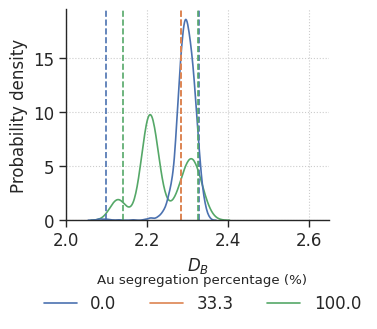

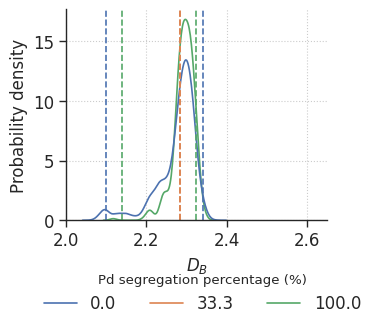

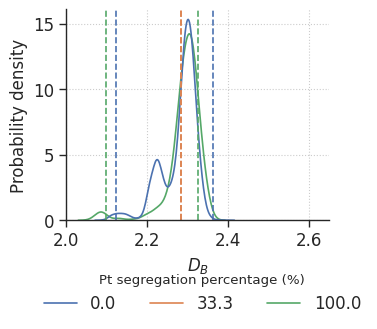

In [30]:
# Distribution of D_B for nanoparticles with different segregation percentages
AuPdPtFeatsNoLowVarHighCorrDF['Au_surf_ratio'] = AuPdPtFeatsNoLowVarHighCorrDF['AuM_SOCN_avg'] / (AuPdPtFeatsNoLowVarHighCorrDF['PdM_SOCN_avg'] + AuPdPtFeatsNoLowVarHighCorrDF['PtM_SOCN_avg'])
AuPdPtFeatsNoLowVarHighCorrDF['Pd_surf_ratio'] = AuPdPtFeatsNoLowVarHighCorrDF['PdM_SOCN_avg'] / (AuPdPtFeatsNoLowVarHighCorrDF['AuM_SOCN_avg'] + AuPdPtFeatsNoLowVarHighCorrDF['PtM_SOCN_avg'])
AuPdPtFeatsNoLowVarHighCorrDF['Pt_surf_ratio'] = AuPdPtFeatsNoLowVarHighCorrDF['PtM_SOCN_avg'] / (AuPdPtFeatsNoLowVarHighCorrDF['AuM_SOCN_avg'] + AuPdPtFeatsNoLowVarHighCorrDF['PdM_SOCN_avg'])
AuPdPtFeatsNoLowVarHighCorrDF['Au_seg_perc'] = np.nan
AuPdPtFeatsNoLowVarHighCorrDF['Au_seg_perc'][AuPdPtFeatsNoLowVarHighCorrDF['Au_surf_ratio'] == 0.0] = 0.0
AuPdPtFeatsNoLowVarHighCorrDF['Au_seg_perc'][(AuPdPtFeatsNoLowVarHighCorrDF['Au_surf_ratio'] ==0.5) & (AuPdPtFeatsNoLowVarHighCorrDF['Pd_surf_ratio'] == 0.5) & (AuPdPtFeatsNoLowVarHighCorrDF['Pt_surf_ratio'] == 0.5)] = 33.3
AuPdPtFeatsNoLowVarHighCorrDF['Au_seg_perc'][(AuPdPtFeatsNoLowVarHighCorrDF['Pd_surf_ratio'] == 0.0) & (AuPdPtFeatsNoLowVarHighCorrDF['Pt_surf_ratio'] == 0.0)] = 100.0
AuPdPtFeatsNoLowVarHighCorrDF['Pd_seg_perc'] = np.nan
AuPdPtFeatsNoLowVarHighCorrDF['Pd_seg_perc'][AuPdPtFeatsNoLowVarHighCorrDF['Pd_surf_ratio'] == 0.0] = 0.0
AuPdPtFeatsNoLowVarHighCorrDF['Pd_seg_perc'][(AuPdPtFeatsNoLowVarHighCorrDF['Au_surf_ratio'] ==0.5) & (AuPdPtFeatsNoLowVarHighCorrDF['Pd_surf_ratio'] == 0.5) & (AuPdPtFeatsNoLowVarHighCorrDF['Pt_surf_ratio'] == 0.5)] = 33.3
AuPdPtFeatsNoLowVarHighCorrDF['Pd_seg_perc'][(AuPdPtFeatsNoLowVarHighCorrDF['Au_surf_ratio'] == 0.0) & (AuPdPtFeatsNoLowVarHighCorrDF['Pt_surf_ratio'] == 0.0)] = 100.0
AuPdPtFeatsNoLowVarHighCorrDF['Pt_seg_perc'] = np.nan
AuPdPtFeatsNoLowVarHighCorrDF['Pt_seg_perc'][AuPdPtFeatsNoLowVarHighCorrDF['Pt_surf_ratio'] == 0.0] = 0.0
AuPdPtFeatsNoLowVarHighCorrDF['Pt_seg_perc'][(AuPdPtFeatsNoLowVarHighCorrDF['Au_surf_ratio'] ==0.5) & (AuPdPtFeatsNoLowVarHighCorrDF['Pd_surf_ratio'] == 0.5) & (AuPdPtFeatsNoLowVarHighCorrDF['Pt_surf_ratio'] == 0.5)] = 33.3
AuPdPtFeatsNoLowVarHighCorrDF['Pt_seg_perc'][(AuPdPtFeatsNoLowVarHighCorrDF['Au_surf_ratio'] == 0.0) & (AuPdPtFeatsNoLowVarHighCorrDF['Pd_surf_ratio'] == 0.0)] = 100.0

# Surface segregation
AuPdPtNPDF = pd.concat([AuPdPtFeatsNoLowVarHighCorrDF, AuPdPtLabelDF], axis=1)
plotBCDhist(df=AuPdPtNPDF.dropna(subset='Au_seg_perc'), figNameAppend='AuPdPtsurfSegAu', splitFeat='Au_seg_perc', titleName='Au segregation percentage (%)', xLims=(2.00, 2.65), threshLines=True, legendXpos=0.45)
plotBCDhist(df=AuPdPtNPDF.dropna(subset='Pd_seg_perc'), figNameAppend='AuPdPtsurfSegPd', splitFeat='Pd_seg_perc', titleName='Pd segregation percentage (%)', xLims=(2.00, 2.65), threshLines=True, legendXpos=0.45)
plotBCDhist(df=AuPdPtNPDF.dropna(subset='Pt_seg_perc'), figNameAppend='AuPdPtsurfSegPt', splitFeat='Pt_seg_perc', titleName='Pt segregation percentage (%)', xLims=(2.00, 2.65), threshLines=True, legendXpos=0.45)

In [17]:
# Group features
processFeats = ['T', 'P']
npStatsFeats = ['N_atom_total', 'N_atom_bulk', 'N_atom_surface', 'Vol_bulk_pack', 'Vol_sphere', 
                'N_bond', 'N_Au', 'N_Pd', 'N_Pt', 'AuAu_frac', 'AuPd_frac', 'AuPt_frac', 'PdPd_frac', 'PdPt_frac', 'PtPt_frac',
                'R_min', 'R_max', 'R_diff', 'R_avg', 'R_std', 'R_skew', 'R_kurt', 'D_avg']
facetFeats = ['S_100', 'S_111', 'S_110', 'S_311', 'Frac_S_100', 'Frac_S_111', 'Frac_S_110', 'Frac_S_311']
curvFeats = [feat for feat in AuPdPtDF.columns if 'Curve' in feat]
tcnFeats = [feat for feat in AuPdPtDF.columns if 'MM_TCN' in feat or 'MM_TGCN' in feat]
bcnFeats = [feat for feat in AuPdPtDF.columns if 'MM_BCN' in feat or 'MM_BGCN' in feat]
scnFeats = [feat for feat in AuPdPtDF.columns if 'MM_SCN' in feat or 'MM_SGCN' in feat or 'MM_SOCN' in feat or 'MM_SOGCN' in feat]
blFeats = [feat for feat in AuPdPtDF.columns if 'MM_BL' in feat]
baFeats = [feat for feat in AuPdPtDF.columns if 'MMM_BA' in feat]
btFeats = [feat for feat in AuPdPtDF.columns if 'MMMM_BT' in feat]
crysFeats = ['FCC', 'HCP', 'ICOS', 'DECA', 'Frac_FCC', 'Frac_HCP', 'Frac_ICOS', 'Frac_DECA']
q6q6tFeats = [feat for feat in AuPdPtDF.columns if 'q6q6_T' in feat]
q6q6bFeats = [feat for feat in AuPdPtDF.columns if 'q6q6_B' in feat]
q6q6sFeats = [feat for feat in AuPdPtDF.columns if 'q6q6_S' in feat]

In [ ]:
# Correlations between box-counting dimension and features
plotFeatsBCDcorr(df=AuPdPtDF, feats=processFeats, figNameAppend='TNP', titleName='Elements', showPlot=True)
plotFeatsBCDcorr(df=AuPdPtDF, feats=npStatsFeats, figNameAppend='TNP', titleName='Elements', showPlot=True)
plotFeatsBCDcorr(df=AuPdPtDF, feats=facetFeats, figNameAppend='TNP', titleName='Elements', showPlot=True)
plotFeatsBCDcorr(df=AuPdPtDF, feats=curvFeats, figNameAppend='TNP', titleName='Elements', showPlot=True)
plotFeatsBCDcorr(df=AuPdPtDF, feats=tcnFeats, figNameAppend='TNP', titleName='Elements', showPlot=True)
plotFeatsBCDcorr(df=AuPdPtDF, feats=bcnFeats, figNameAppend='TNP', titleName='Elements', showPlot=True)
plotFeatsBCDcorr(df=AuPdPtDF, feats=scnFeats, figNameAppend='TNP', titleName='Elements', showPlot=True)
plotFeatsBCDcorr(df=AuPdPtDF, feats=blFeats, figNameAppend='TNP', titleName='Elements', showPlot=True)
plotFeatsBCDcorr(df=AuPdPtDF, feats=baFeats, figNameAppend='TNP', titleName='Elements', showPlot=True)
plotFeatsBCDcorr(df=AuPdPtDF, feats=btFeats, figNameAppend='TNP', titleName='Elements', showPlot=True)
plotFeatsBCDcorr(df=AuPdPtDF, feats=crysFeats, figNameAppend='TNP', titleName='Elements', showPlot=True)
plotFeatsBCDcorr(df=AuPdPtDF, feats=q6q6tFeats, figNameAppend='TNP', titleName='Elements', showPlot=True)
plotFeatsBCDcorr(df=AuPdPtDF, feats=q6q6bFeats, figNameAppend='TNP', titleName='Elements', showPlot=True)
plotFeatsBCDcorr(df=AuPdPtDF, feats=q6q6sFeats, figNameAppend='TNP', titleName='Elements', showPlot=True)

In [18]:
# Calculate the number of hypotheses for Bonferroni correction
feats = processFeats + npStatsFeats + facetFeats + curvFeats + tcnFeats + bcnFeats + scnFeats + blFeats + baFeats + btFeats + crysFeats + q6q6tFeats + q6q6bFeats + q6q6sFeats
splitFeat = 'Elements'
numHypothesis = countNumHypothesis(df=AuPdPtDF, feats=feats, splitFeat=splitFeat)

Feature: T
Feature: P
Feature: N_atom_total
Feature: N_atom_bulk
Feature: N_atom_surface
Feature: Vol_bulk_pack
Feature: Vol_sphere
Feature: N_bond
Feature: N_Au
Feature: N_Pd
Feature: N_Pt
Feature: AuAu_frac
Feature: AuPd_frac
Feature: AuPt_frac
Feature: PdPd_frac
Feature: PdPt_frac
Feature: PtPt_frac
Feature: R_min
Feature: R_max
Feature: R_diff
Feature: R_avg
Feature: R_std
Feature: R_skew
Feature: R_kurt
Feature: D_avg
Feature: S_100
Feature: S_111
Feature: S_110
Feature: S_311
Feature: Frac_S_100
Feature: Frac_S_111
Feature: Frac_S_110
Feature: Frac_S_311
Feature: Curve_1-10
Feature: Curve_11-20
Feature: Curve_21-30
Feature: Curve_31-40
Feature: Curve_41-50
Feature: Curve_51-60
Feature: Curve_61-70
Feature: Curve_71-80
Feature: Frac_Curve_1-10
Feature: Frac_Curve_11-20
Feature: Frac_Curve_21-30
Feature: Frac_Curve_31-40
Feature: Frac_Curve_41-50
Feature: Frac_Curve_51-60
Feature: Frac_Curve_61-70
Feature: Frac_Curve_71-80
Feature: MM_TCN_avg
Feature: MM_TGCN_avg
Feature: MM_TCN_0


In [ ]:
mis = calcMIs(df=AuPdPtDF, feats=processFeats, splitFeat='Elements', numHypothesis=numHypothesis)
mis = calcMIs(df=AuPdPtDF, feats=npStatsFeats, splitFeat='Elements', numHypothesis=numHypothesis)
mis = calcMIs(df=AuPdPtDF, feats=facetFeats, splitFeat='Elements', numHypothesis=numHypothesis)
mis = calcMIs(df=AuPdPtDF, feats=curvFeats, splitFeat='Elements', numHypothesis=numHypothesis)
mis = calcMIs(df=AuPdPtDF, feats=tcnFeats, splitFeat='Elements', numHypothesis=numHypothesis)
mis = calcMIs(df=AuPdPtDF, feats=bcnFeats, splitFeat='Elements', numHypothesis=numHypothesis)
mis = calcMIs(df=AuPdPtDF, feats=scnFeats, splitFeat='Elements', numHypothesis=numHypothesis)
mis = calcMIs(df=AuPdPtDF, feats=blFeats, splitFeat='Elements', numHypothesis=numHypothesis)
mis = calcMIs(df=AuPdPtDF, feats=baFeats, splitFeat='Elements', numHypothesis=numHypothesis)
mis = calcMIs(df=AuPdPtDF, feats=crysFeats, splitFeat='Elements', numHypothesis=numHypothesis)
mis = calcMIs(df=AuPdPtDF, feats=q6q6tFeats, splitFeat='Elements', numHypothesis=numHypothesis)
mis = calcMIs(df=AuPdPtDF, feats=q6q6bFeats, splitFeat='Elements', numHypothesis=numHypothesis)
mis = calcMIs(df=AuPdPtDF, feats=q6q6sFeats, splitFeat='Elements', numHypothesis=numHypothesis)

## All Nanoparticles

In [ ]:
# Create master dataframe
MNPDF['typeNP'] = 'MNP'
MNPDF['AuAu_frac'] = 0
AuAu_fracSeries = MNPDF['AuAu_frac'].copy()
AuAu_fracSeries[MNPDF['Elements'] == 'Au'] = MNPDF['N_atom_total'][MNPDF['Elements'] == 'Au']
MNPDF['AuAu_frac'] = AuAu_fracSeries
MNPDF['AuPd_frac'] = 0
MNPDF['AuPt_frac'] = 0
MNPDF['PdPd_frac'] = 0
PdPd_fracSeries = MNPDF['PdPd_frac'].copy()
PdPd_fracSeries[MNPDF['Elements'] == 'Pd'] = MNPDF['N_atom_total'][MNPDF['Elements'] == 'Pd']
MNPDF['PdPd_frac'] = PdPd_fracSeries
MNPDF['PdPt_frac'] = 0
MNPDF['PtPt_frac'] = 0
PtPt_fracSeries = MNPDF['PdPd_frac'].copy()
PtPt_fracSeries[MNPDF['Elements'] == 'Pt'] = MNPDF['N_atom_total'][MNPDF['Elements'] == 'Pt']
MNPDF['PtPt_frac'] = MNPDF['N_atom_total']
MNPDF['PtPt_frac'] = PtPt_fracSeries

BNPDF = BNPDF.rename({'Vol_bulk_pack': 'Volume'}, axis=1)
BNPDF['typeNP'] = 'BNP'
AuPdPtDF = AuPdPtDF.rename({'Vol_bulk_pack': 'Volume'}, axis=1)
AuPdPtDF['typeNP'] = 'TNP'
allNPDF = pd.concat([BNPDF, AuPdPtDF, MNPDF], axis=0)
allNPDF = allNPDF.reset_index(inplace=False)
allNPDF = allNPDF.drop(['index'], axis=1, inplace=False)
# allNPDF = rmNullLowVarFeats(allNPDF, rmNull=True, varThresh=0.0, verbose=True)

In [ ]:
# Comparison between the average radius of rough and smooth nanoparticles
roughThresh = 2.45
roughness = allNPDF['DBoxEX'].copy().rename('Roughness')
roughness.loc[:] = np.nan
roughness[allNPDF['DBoxEX'] > roughThresh] = '> 2.45'
roughness[allNPDF['DBoxEX'] < roughThresh] = '< 2.45'
roughness = pd.concat([allNPDF['D_avg'], roughness], axis=1)

# Reminder to change the sns.move_legend() function under plotBCDhist() in corrAnalysis.py before running the next line
plotBCDhist(df=roughness, figNameAppend='roughness', splitFeat='Roughness', titleName=r'$D_B$', 
            xFeat='D_avg', xLabel='Average diameter (nm)', xLims=None, threshLines=False)  # (2.00, 2.65)

In [ ]:
# Identification of the D_B values where the peaks of KDEs are
df = roughness
splitFeat = 'Roughness'
xFeat = 'D_avg'

hueOrder = ['BNP', 'TNP', 'MNP'] if splitFeat == 'typeNP' else sorted(df[splitFeat].unique())
g = sns.displot(data=df, x=xFeat, y=None, hue=splitFeat, row=None, col=None,
                weights=None, kind='kde', rug=False, rug_kws=None, log_scale=None, 
                legend=True, palette='deep', hue_order=hueOrder, hue_norm=None, color=None, col_wrap=None, 
                row_order=None, col_order=None, height=3, aspect=1.2, facet_kws=None, common_norm=False)
plt.close()

kdeSmooth = g.ax.get_children()[0].get_data()[1]
dAvgMaxSmooth = g.ax.get_children()[0].get_data()[0][np.argmax(kdeSmooth)]
kdeRough = g.ax.get_children()[1].get_data()[1]
dAvgMaxRough = g.ax.get_children()[1].get_data()[0][np.argmax(kdeRough)]
print(f"Average diameters for nanoparticles with D_B\n\tbelow 2.45: {dAvgMaxSmooth:.3f} nm\n\tabove 2.45: {dAvgMaxRough:.3f} nm")

In [ ]:
# Distribution of box-counting dimension
plotBCDhist(df=allNPDF.loc[:, ['DBoxEX', 'typeNP']], figNameAppend='allNP', splitFeat='typeNP', titleName='Type', xLims=None, threshLines=True)  # (2.00, 2.65)

# Statistics
sigDiffNPDF = compareRoughSmoothStats(df=allNPDF)
sigDiffNPDF

In [ ]:
# Group features
processFeats = ['T', 'P']
npStatsFeats = ['N_atom_total', 'N_atom_bulk', 'N_atom_surface', 'Volume', 'Vol_sphere',
                'N_Au', 'N_Pd', 'N_Pt', 'AuAu_frac', 'AuPd_frac', 'AuPt_frac', 'PdPd_frac', 'PdPt_frac', 'PtPt_frac',
                'R_min', 'R_max', 'R_diff', 'R_avg', 'R_std', 'R_skew', 'R_kurt', 'D_avg']
facetFeats = ['S_100', 'S_111', 'S_110', 'S_311', 'Frac_S_100', 'Frac_S_111', 'Frac_S_110', 'Frac_S_311']
curvFeats = [feat for feat in allNPDF.columns if 'Curve' in feat]
tcnFeats = [feat for feat in allNPDF.columns if 'MM_TCN' in feat or 'MM_TGCN' in feat]
bcnFeats = [feat for feat in allNPDF.columns if 'MM_BCN' in feat or 'MM_BGCN' in feat]
scnFeats = [feat for feat in allNPDF.columns if 'MM_SCN' in feat or 'MM_SGCN' in feat or 'MM_SOCN' in feat or 'MM_SOGCN' in feat]
blFeats = [feat for feat in allNPDF.columns if 'MM_BL' in feat]
baFeats = [feat for feat in allNPDF.columns if 'MMM_BA' in feat]
btFeats = [feat for feat in allNPDF.columns if 'MMM_BT' in feat]
crysFeats = ['FCC', 'HCP', 'ICOS', 'DECA', 'Frac_FCC', 'Frac_HCP', 'Frac_ICOS', 'Frac_DECA']
q6q6tFeats = [feat for feat in allNPDF.columns if 'q6q6_T' in feat]
q6q6bFeats = [feat for feat in allNPDF.columns if 'q6q6_B' in feat]
q6q6sFeats = [feat for feat in allNPDF.columns if 'q6q6_S' in feat]

In [ ]:
# Correlations between box-counting dimension and features
plotFeatsBCDcorr(df=allNPDF, feats=processFeats, figNameAppend='allNP', splitFeat='typeNP', titleName='Type', showPlot=True)
plotFeatsBCDcorr(df=allNPDF, feats=npStatsFeats, figNameAppend='allNP', splitFeat='typeNP', titleName='Type', 
                 sciNotation=['N_atom_total', 'N_atom_bulk', 'N_atom_surface', 'Volume', 'N_Au', 'N_Pd', 'N_Pt'], showPlot=True)
plotFeatsBCDcorr(df=allNPDF, feats=facetFeats, figNameAppend='allNP', splitFeat='typeNP', titleName='Type', 
                 sciNotation=['S_100', 'S_111', 'S_110', 'S_311'], showPlot=True)
plotFeatsBCDcorr(df=allNPDF, feats=curvFeats, figNameAppend='allNP', splitFeat='typeNP', titleName='Type', 
                 sciNotation=curvFeats, showPlot=True)
plotFeatsBCDcorr(df=allNPDF, feats=tcnFeats, figNameAppend='allNP', splitFeat='typeNP', titleName='Type', showPlot=True)
plotFeatsBCDcorr(df=allNPDF, feats=bcnFeats, figNameAppend='allNP', splitFeat='typeNP', titleName='Type', showPlot=True)
plotFeatsBCDcorr(df=allNPDF, feats=scnFeats, figNameAppend='allNP', splitFeat='typeNP', titleName='Type', showPlot=True)
plotFeatsBCDcorr(df=allNPDF, feats=blFeats, figNameAppend='allNP', splitFeat='typeNP', titleName='Type', showPlot=True)
plotFeatsBCDcorr(df=allNPDF, feats=baFeats, figNameAppend='allNP', splitFeat='typeNP', titleName='Type', showPlot=True)
plotFeatsBCDcorr(df=allNPDF, feats=crysFeats, figNameAppend='allNP', splitFeat='typeNP', titleName='Type', 
                 sciNotation=['Frac_ICOS'], showPlot=True)
plotFeatsBCDcorr(df=allNPDF, feats=q6q6tFeats, figNameAppend='allNP', splitFeat='typeNP', titleName='Type', showPlot=True)
plotFeatsBCDcorr(df=allNPDF, feats=q6q6bFeats, figNameAppend='allNP', splitFeat='typeNP', titleName='Type', showPlot=True)
plotFeatsBCDcorr(df=allNPDF, feats=q6q6sFeats, figNameAppend='allNP', splitFeat='typeNP', titleName='Type', showPlot=True)

In [ ]:
# Calculate the number of hypotheses for Bonferroni correction
feats = processFeats + npStatsFeats + facetFeats + curvFeats + tcnFeats + bcnFeats + scnFeats + blFeats + baFeats + btFeats + crysFeats + q6q6tFeats + q6q6bFeats + q6q6sFeats
splitFeat = 'typeNP'
numHypothesis = countNumHypothesis(df=allNPDF, feats=feats, splitFeat=splitFeat)

In [ ]:
mis = calcMIs(df=allNPDF, feats=processFeats, splitFeat='typeNP', numHypothesis=numHypothesis)
mis = calcMIs(df=allNPDF, feats=npStatsFeats, splitFeat='typeNP', numHypothesis=numHypothesis)
mis = calcMIs(df=allNPDF, feats=facetFeats, splitFeat='typeNP', numHypothesis=numHypothesis)
mis = calcMIs(df=allNPDF, feats=curvFeats, splitFeat='typeNP', numHypothesis=numHypothesis)
mis = calcMIs(df=allNPDF, feats=tcnFeats, splitFeat='typeNP', numHypothesis=numHypothesis)
mis = calcMIs(df=allNPDF, feats=bcnFeats, splitFeat='typeNP', numHypothesis=numHypothesis)
mis = calcMIs(df=allNPDF, feats=scnFeats, splitFeat='typeNP', numHypothesis=numHypothesis)
mis = calcMIs(df=allNPDF, feats=blFeats, splitFeat='typeNP', numHypothesis=numHypothesis)
mis = calcMIs(df=allNPDF, feats=baFeats, splitFeat='typeNP', numHypothesis=numHypothesis)
mis = calcMIs(df=allNPDF, feats=crysFeats, splitFeat='typeNP', numHypothesis=numHypothesis)
mis = calcMIs(df=allNPDF, feats=q6q6tFeats, splitFeat='typeNP', numHypothesis=numHypothesis)
mis = calcMIs(df=allNPDF, feats=q6q6bFeats, splitFeat='typeNP', numHypothesis=numHypothesis)
mis = calcMIs(df=allNPDF, feats=q6q6sFeats, splitFeat='typeNP', numHypothesis=numHypothesis)